In [52]:
# Import all needed packages
import psycopg2
import pandas as pd
import pandas.io.sql as pdsql
import numpy as np
import seaborn as sns 
import matplotlib.pyplot as plt 

from pandas.tools.plotting import scatter_matrix
from sklearn import cross_validation as cv
from sklearn.cross_validation import train_test_split as tts
from sklearn.decomposition import PCA
from sklearn.feature_selection import SelectFromModel
from sklearn.linear_model import Ridge, RandomizedLasso, ElasticNet, LinearRegression
from sklearn.ensemble import RandomForestRegressor

from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error as mse

## Pull In Data From Postgres Database

In [53]:
# Connect to AWS Database
con=psycopg2.connect(dbname= 'DCZillow', 
                     host='dczillow.cfdlhqngxmri.us-east-1.rds.amazonaws.com',
                     port='5432',
                     user= 'DCZillow', 
                     password= 'DCZillow');

cur = con.cursor()

In [54]:
# Pull in weekly Zillow API call data
df = pdsql.read_sql("""SELECT * FROM zillow_weekly""", con)

# Select only the columns needed for analysis / modeling
df1 = df[['bedrooms', 'bathrooms', 'yearbuilt', 'lotsizesqft', 'taxassessment_6','finishedsqft',
         'for_sale','zpid','street','city','state','zipcode',
          'zestimate_1', 'zestimate_6', 'percentile_1', 'percentile_6', 'lastsolddate_6', 'lastsoldprice_6']]

In [55]:
# Pull Aggregated Basic Business License Change by Zipcode
df_lic_sum = pdsql.read_sql("""SELECT * FROM license_summary_float""", con)

df_lic_sum.loc[:,'bbl_pct_chg_1617'] = df_lic_sum['growth_yoy']
df_lic_sum.loc[:,'bbl_pct_chg_1217'] = df_lic_sum['growth_yoy_5']

df_lic_sum1 = df_lic_sum[['zipcode', 'bbl_pct_chg_1617', 'bbl_pct_chg_1217']]


In [56]:
# Pull Basic Business License Category Change by Zipcode
df_lic_cat_xtab_6m= pdsql.read_sql("""SELECT * FROM lic_cat_crosstab_6m_yoy""", con)
df_lic_cat_xtab_6m.fillna(0)

,zipcode,barber_shop,cigarette_retail,delicatessen,food_products,parking_facility_attendant,grocery_store,special_events,charitable_solicitation,home_improvement_salesman,...,parking_facility,gen_contr_construction_mngr,consumer_goods_auto_repair,apartment,two_family_rental,home_improvement_contractor,general_business_licenses,patent_medicine,restaurant,one_family_rental
0,20016,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,2.000000,0.000000,-0.500000,...,0.000000,0.272727,0.000000,-0.230769,0.000000,0.000000,-0.448560,0.000000,-0.795322,0.104396
1,20005,0.0,0.000000,0.000000,0.000000,2.727273,0.000000,0.000000,3.566038,0.000000,...,-0.083333,-0.866197,0.000000,0.000000,0.000000,0.000000,0.320069,-0.875000,-0.457831,0.000000
2,20036,0.0,0.000000,0.000000,0.000000,-0.080000,0.000000,0.000000,0.753623,0.000000,...,-0.333333,0.222222,0.000000,0.000000,0.000000,0.000000,0.558659,0.000000,-0.758929,0.172589
3,20037,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,-0.333333,0.000000,0.000000,0.358209,0.000000,-0.023121,0.435583
4,20004,0.0,0.000000,2.666667,-0.571429,1.444444,0.000000,-0.571429,12.454545,0.000000,...,1.333333,0.000000,0.000000,0.000000,0.000000,0.000000,0.022727,-0.400000,-0.306452,-0.419643
5,20007,0.0,0.000000,1.272727,-0.950704,0.000000,0.000000,0.000000,1.555556,0.000000,...,-0.333333,0.000000,0.000000,4.906250,0.000000,0.000000,0.946602,0.000000,-0.746544,0.000000
6,20017,0.0,0.000000,3.666667,0.000000,0.000000,0.000000,0.000000,0.000000,0.200000,...,0.000000,0.000000,0.000000,1.107143,0.000000,0.000000,-0.637255,0.000000,0.000000,0.106557
7,20008,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.019802,0.000000,-0.375000,0.117438
8,20002,0.0,-0.150000,0.377778,2.057692,0.000000,1.055556,0.000000,0.640000,-0.090909,...,0.000000,0.029412,0.111111,-0.323442,0.057895,0.000000,-0.247232,-0.791667,0.500000,0.238158
9,20003,0.0,-0.944444,0.000000,0.000000,1.000000,0.000000,-0.500000,0.000000,-0.125000,...,0.000000,0.071429,0.000000,2.784314,0.120000,0.000000,0.090909,0.000000,1.765625,0.646552


In [57]:
# Pull ZHVI Change by Zipcode
df_zhvi= pdsql.read_sql("""SELECT * FROM zhvi""", con)

columns = ('mom','qoq','yoy','fiveyear','tenyear','peakmonth','peakmonth','peakquarter','pctfallfrompeak')
col_prefix = 'zhvi_'

for i in columns:
    newvar = col_prefix + str(i)
    df_zhvi.rename(columns={i : newvar}, inplace=True)
    
df_zhvi.rename(columns={'regionname' : 'zipcode'}, inplace=True)
df_zhvi.loc[:,'zhvi_peakmonth'] = pd.to_datetime(df_zhvi['zhvi_peakmonth'])
df_zhvi.loc[:,'lasttimeatcurrzhvi'] = pd.to_datetime(df_zhvi['lasttimeatcurrzhvi'])

df_zhvi1 = df_zhvi[['zipcode', 'sizerank', 'zhvi','zhvi_mom','zhvi_qoq','zhvi_yoy','zhvi_fiveyear','zhvi_tenyear',
                    'zhvi_peakmonth','peakzhvi','zhvi_pctfallfrompeak','lasttimeatcurrzhvi']]
df_zhvi1.fillna(0)

,zipcode,sizerank,zhvi,zhvi_mom,zhvi_qoq,zhvi_yoy,zhvi_fiveyear,zhvi_tenyear,zhvi_peakmonth,peakzhvi,zhvi_pctfallfrompeak,lasttimeatcurrzhvi
0,20009,27,565400,-0.006152,-0.005977,0.064383,0.052053,0.024720,2017-03-01,572200,-0.011884,2017-02-01
1,20002,28,612700,-0.007291,-0.003091,0.048246,0.101941,0.000000,2017-03-01,619900,-0.011615,2017-02-01
2,20011,140,568900,-0.003852,0.001408,0.107671,0.123579,0.037577,2017-03-01,573000,-0.007155,2017-03-01
3,20019,205,293900,0.006507,0.021195,0.136944,0.119687,0.020936,2017-05-01,293900,0.000000,2017-05-01
4,20001,265,647600,-0.004764,-0.005681,0.065657,0.083636,0.040571,2017-03-01,653800,-0.009483,2017-02-01
5,20020,361,307800,-0.006135,-0.010608,0.081518,0.114632,0.018479,2017-03-01,311800,-0.012829,2017-01-01
6,20008,1225,856100,-0.004072,0.003634,0.054570,0.044144,0.018017,2017-03-01,860100,-0.004651,2017-03-01
7,20032,1576,278300,0.012368,0.032653,0.108323,0.100896,0.014032,2017-05-01,278300,0.000000,2017-05-01
8,20016,1883,983100,-0.004557,-0.003548,0.052119,0.052494,0.026411,2017-03-01,991200,-0.008172,2017-02-01
9,20003,2048,742500,-0.004158,-0.010528,0.061472,0.077594,0.036841,2017-03-01,751200,-0.011581,2017-02-01


In [58]:
# Close connection to the database
cur.close()
con.close()

In [59]:
# Merge Weekly Zillow + Aggregated BBL Change + BBL Category Change + ZHVI Change
merged = pd.merge(df1,
                 df_lic_sum1,
                 on='zipcode', 
                 how='left')

merged1 = pd.merge(merged,
                 df_lic_cat_xtab_6m,
                 on='zipcode', 
                 how='left')

merged2 = pd.merge(merged1,
                 df_zhvi1,
                 on='zipcode', 
                 how='left')

merged2.shape

(4690, 53)

## Treat Variables and Create Target
Target is defined as (Sold Price / Zestimate)

In [60]:
# Some variables were pulled into the database as the incorrect type. Correcting format here.

merged2.loc[:,'lastsolddate_6'] = pd.to_datetime(merged2['lastsolddate_6'])
merged2.loc[:,'bathrooms'] = pd.to_numeric(merged2['bathrooms'], errors='coerse')
merged2.loc[:,'lotsizesqft'] = merged2['lotsizesqft'].astype(int)
merged2.loc[:,'target_2017'] = abs(df1['lastsoldprice_6'] - df1['zestimate_6'])

merged3= merged2.dropna(subset=['zpid'])

merged3.index = merged3['lastsolddate_6']
merged4=merged3['1/1/2017':]
list(merged4)

['bedrooms',
 'bathrooms',
 'yearbuilt',
 'lotsizesqft',
 'taxassessment_6',
 'finishedsqft',
 'for_sale',
 'zpid',
 'street',
 'city',
 'state',
 'zipcode',
 'zestimate_1',
 'zestimate_6',
 'percentile_1',
 'percentile_6',
 'lastsolddate_6',
 'lastsoldprice_6',
 'bbl_pct_chg_1617',
 'bbl_pct_chg_1217',
 'barber_shop',
 'cigarette_retail',
 'delicatessen',
 'food_products',
 'parking_facility_attendant',
 'grocery_store',
 'special_events',
 'charitable_solicitation',
 'home_improvement_salesman',
 'secondhand_dealers_a',
 'motor_vehicle_salesman',
 'beauty_shop',
 'parking_facility',
 'gen_contr_construction_mngr',
 'consumer_goods_auto_repair',
 'apartment',
 'two_family_rental',
 'home_improvement_contractor',
 'general_business_licenses',
 'patent_medicine',
 'restaurant',
 'one_family_rental',
 'sizerank',
 'zhvi',
 'zhvi_mom',
 'zhvi_qoq',
 'zhvi_yoy',
 'zhvi_fiveyear',
 'zhvi_tenyear',
 'zhvi_peakmonth',
 'peakzhvi',
 'zhvi_pctfallfrompeak',
 'lasttimeatcurrzhvi',
 'target_2017'

## Visual Data Analysis

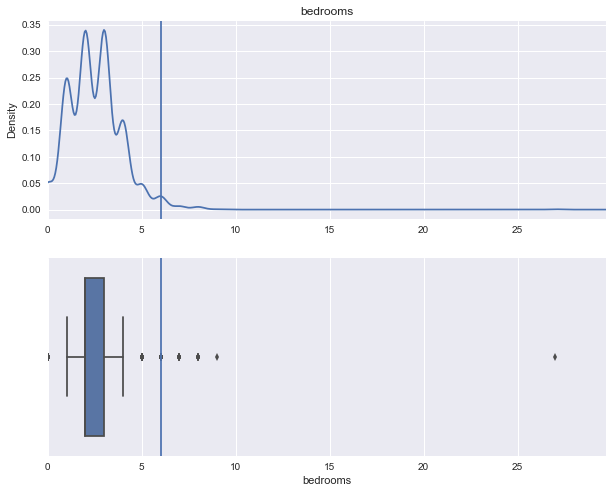

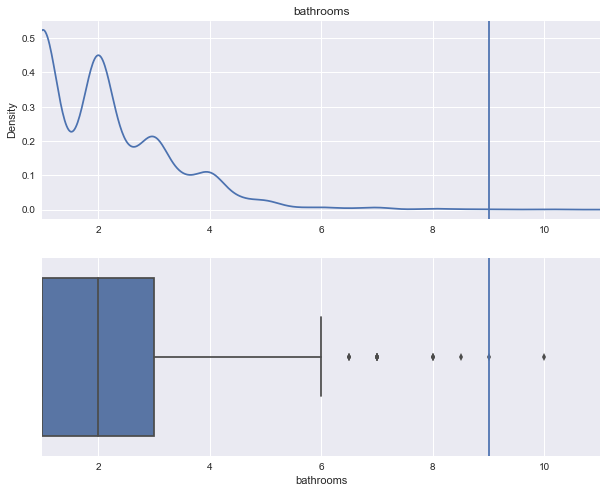

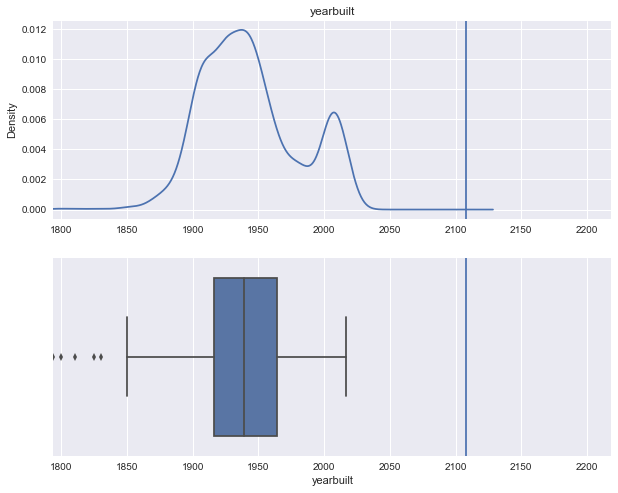

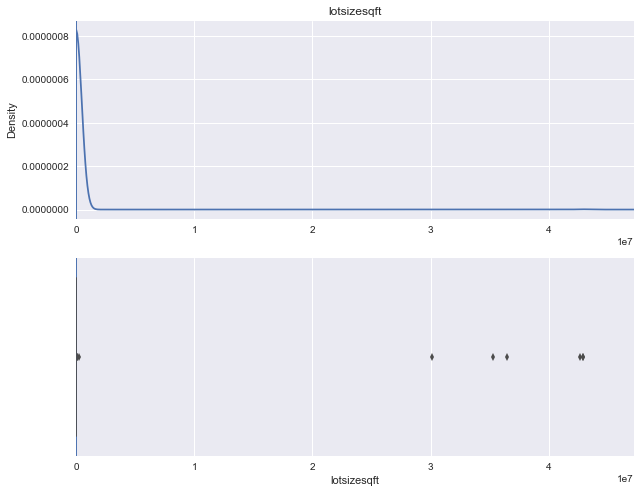

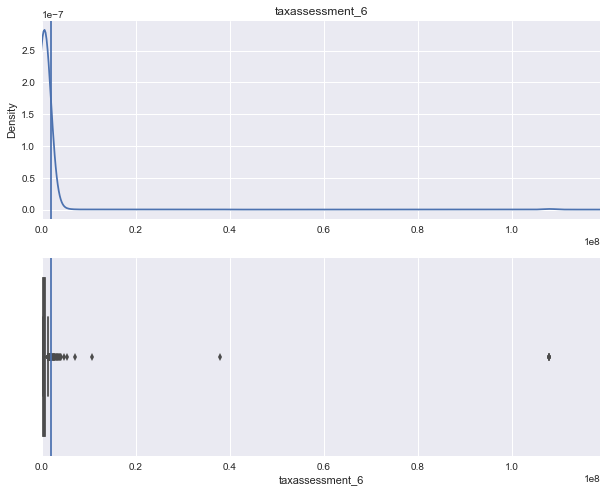

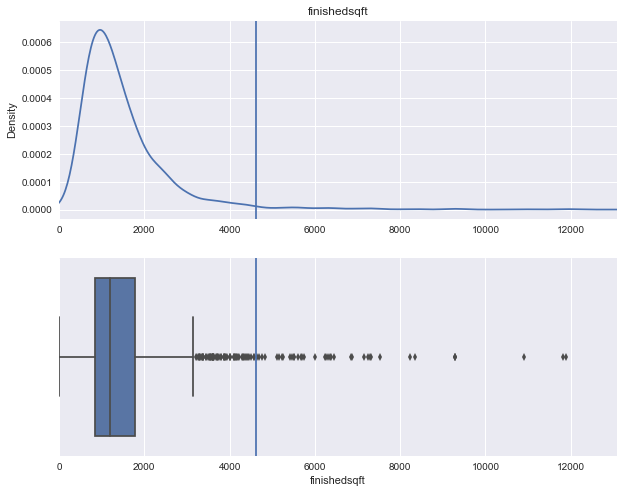

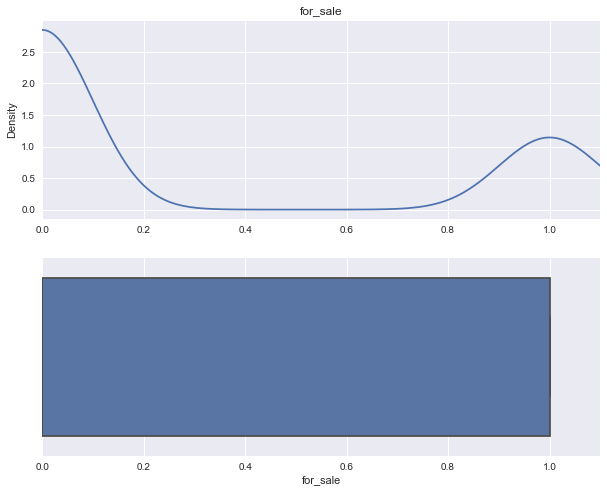

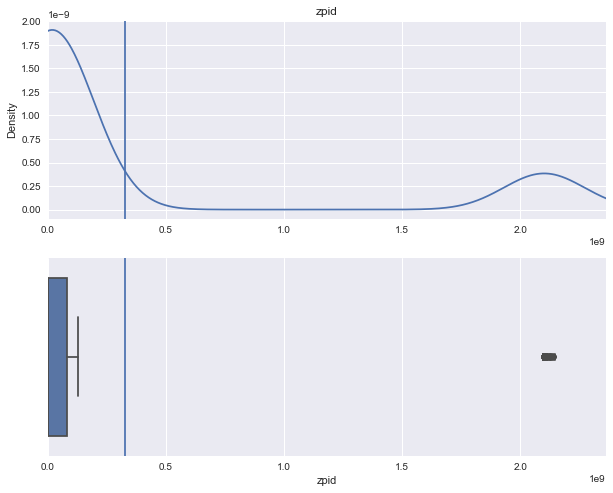

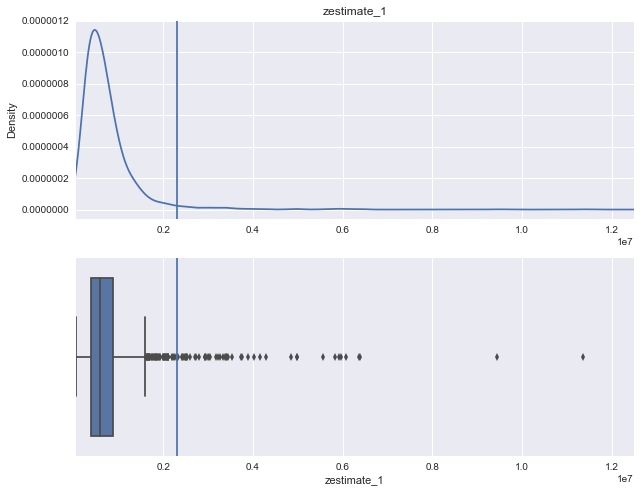

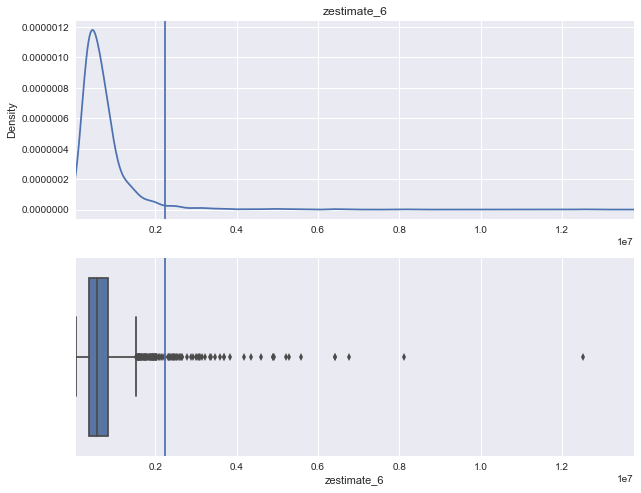

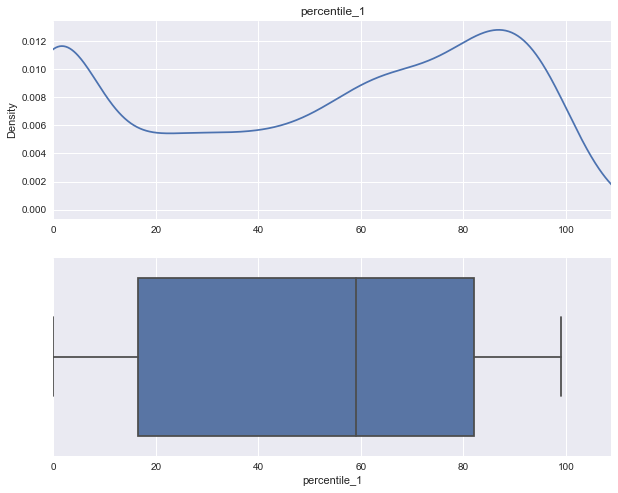

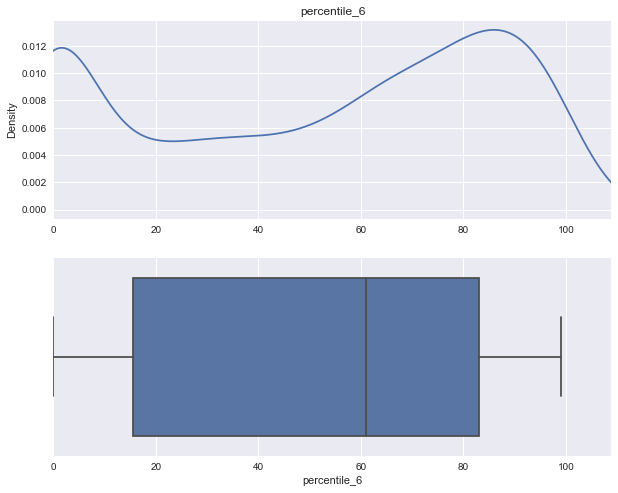

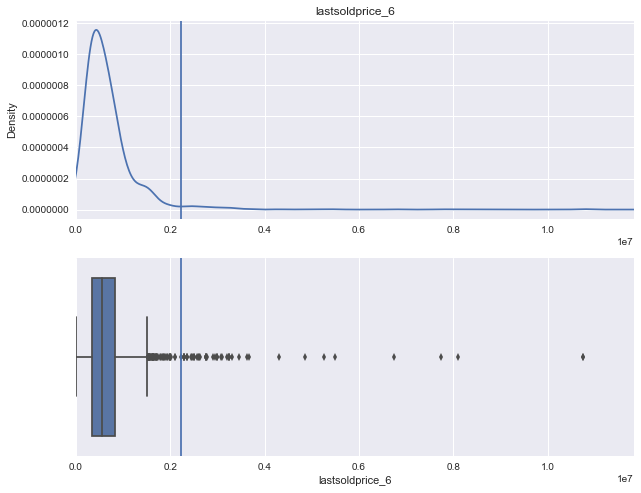

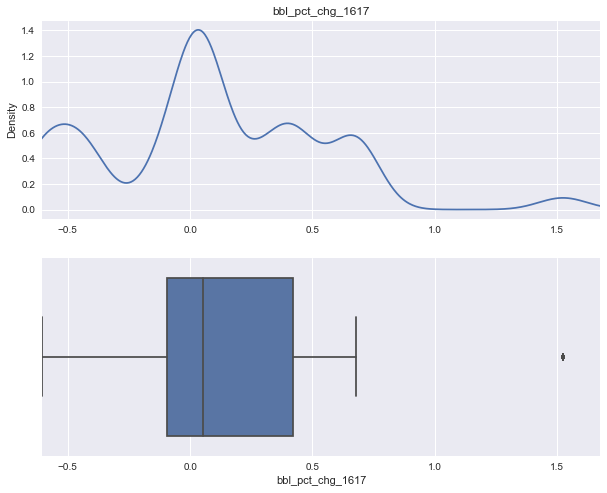

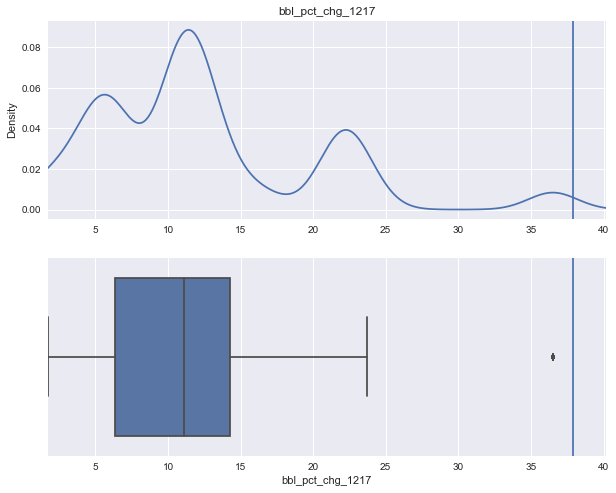

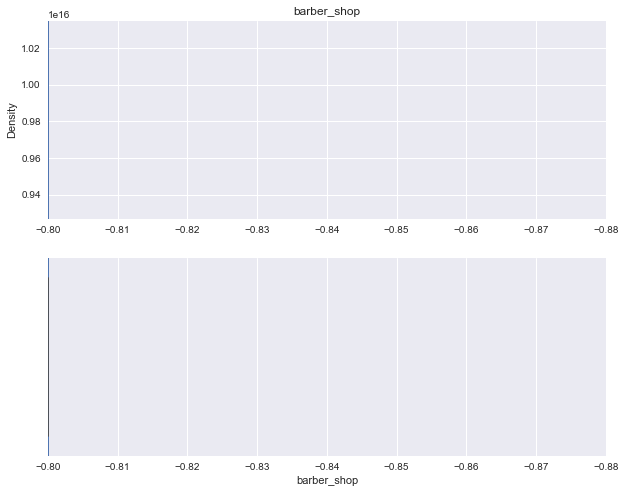

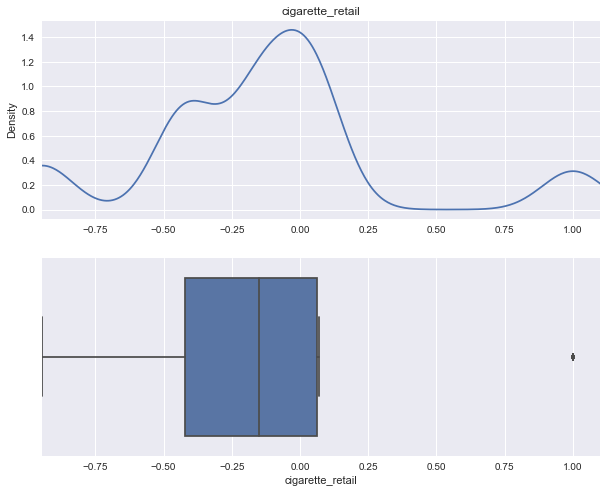

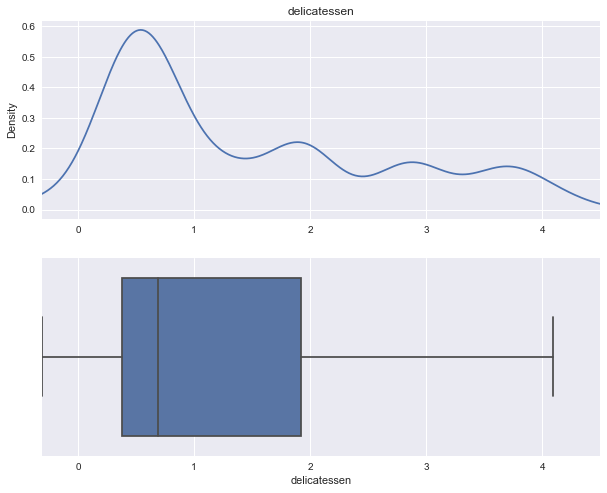

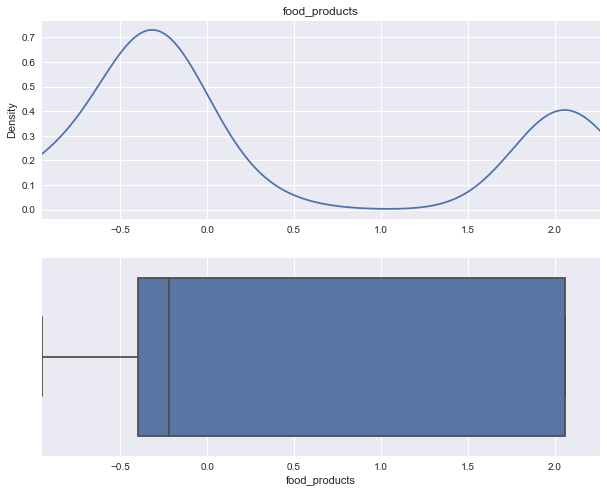

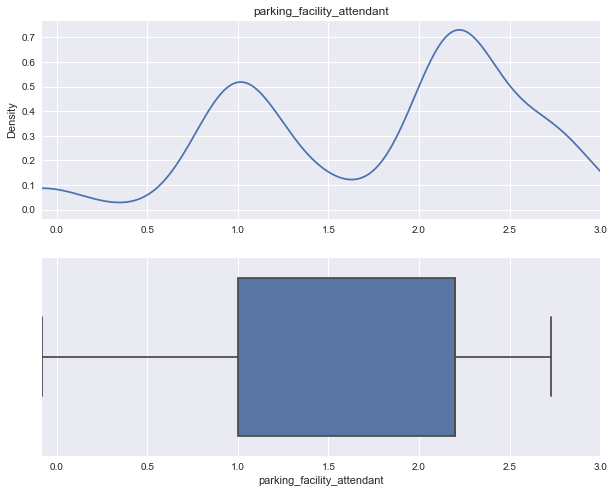

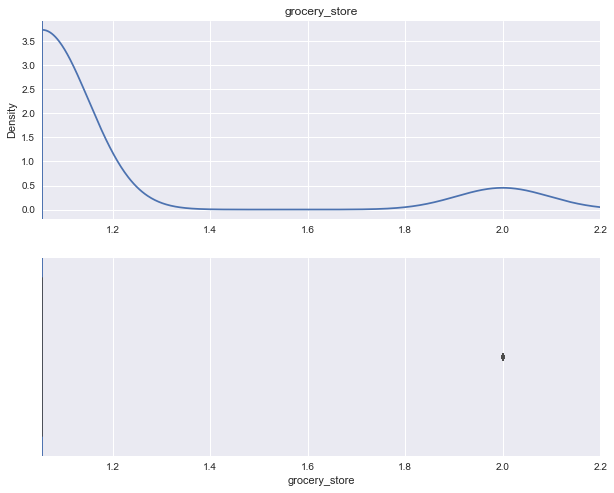

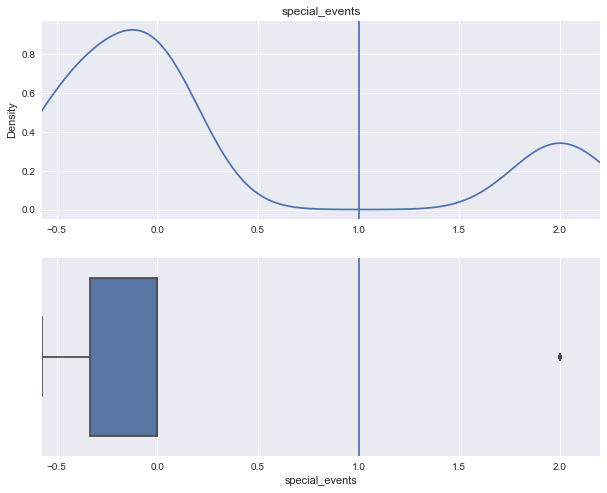

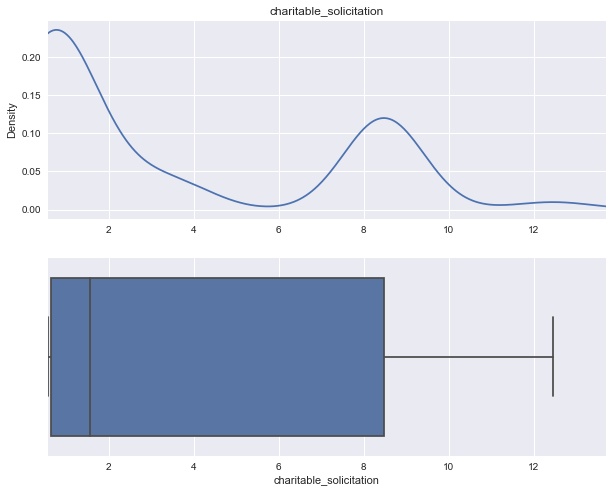

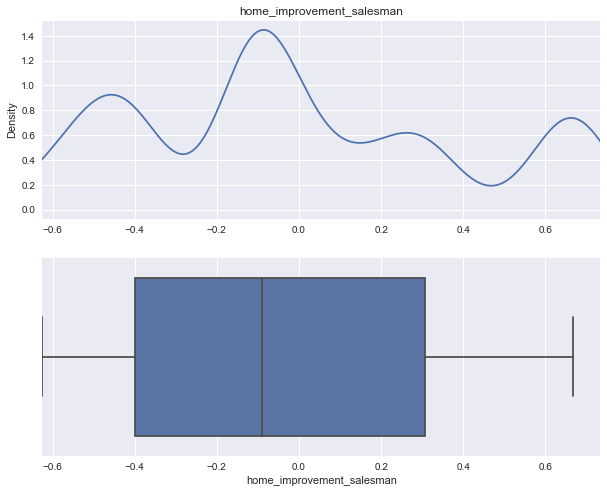

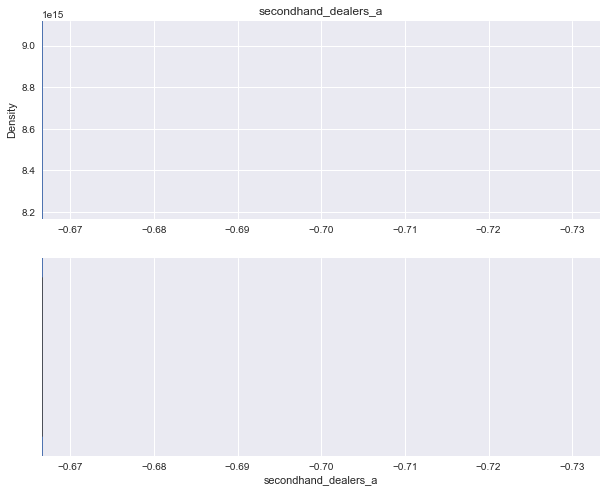

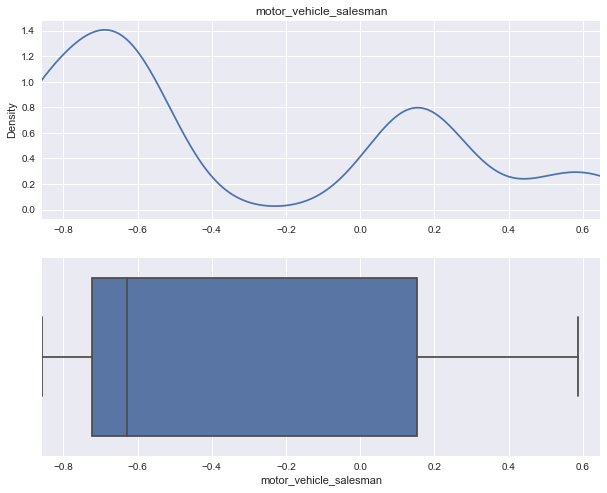

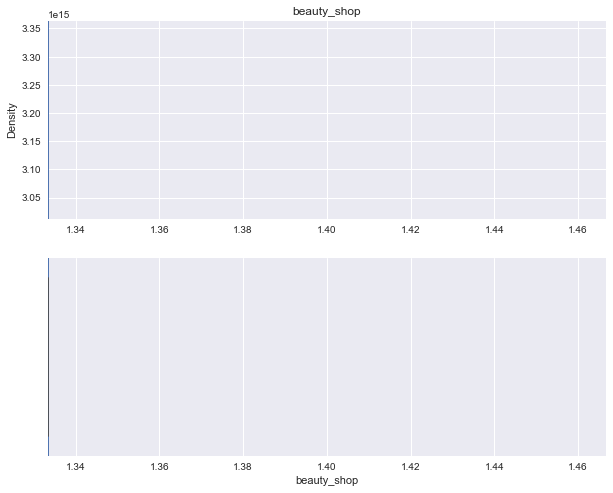

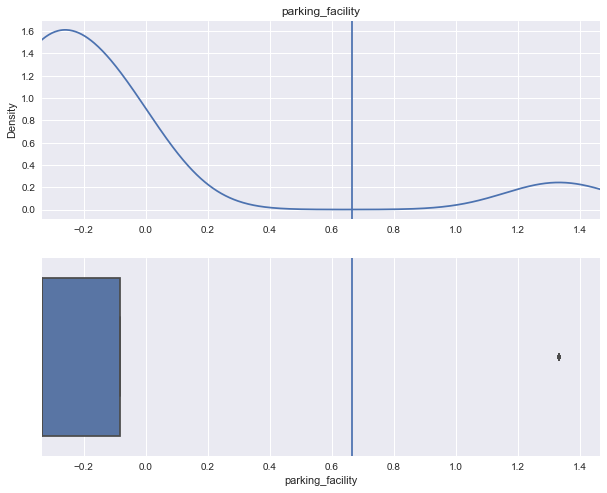

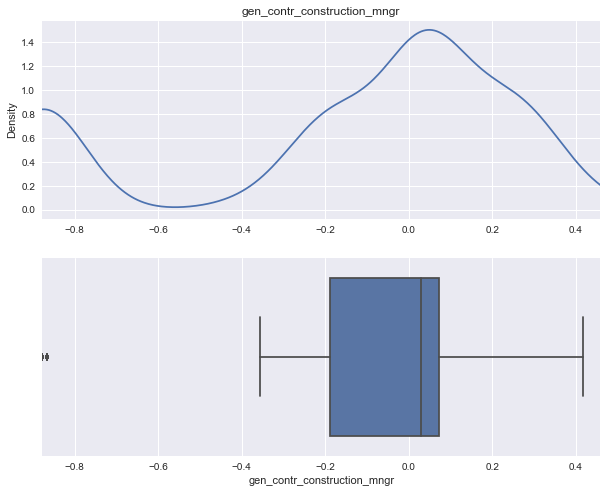

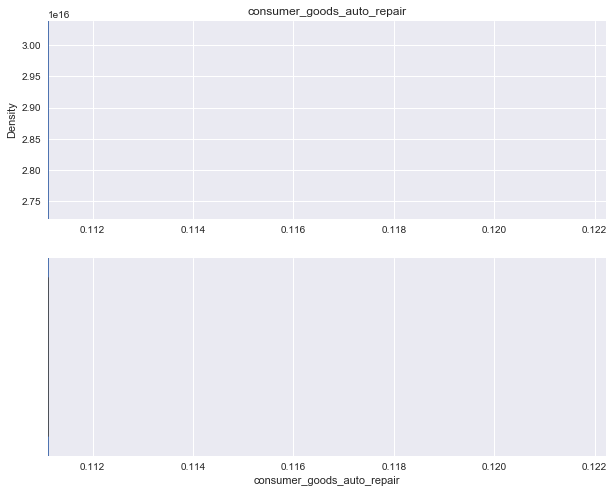

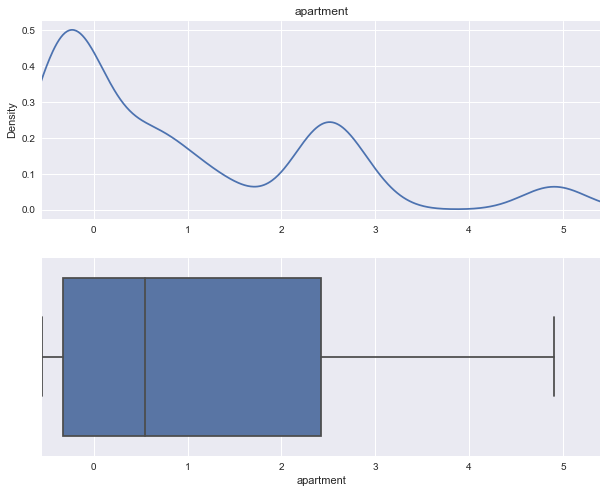

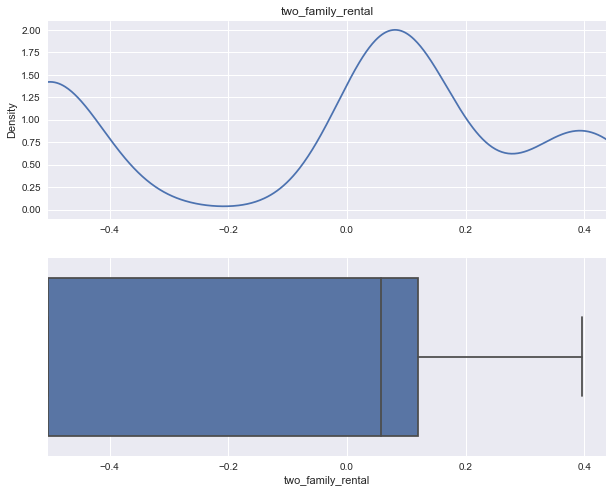

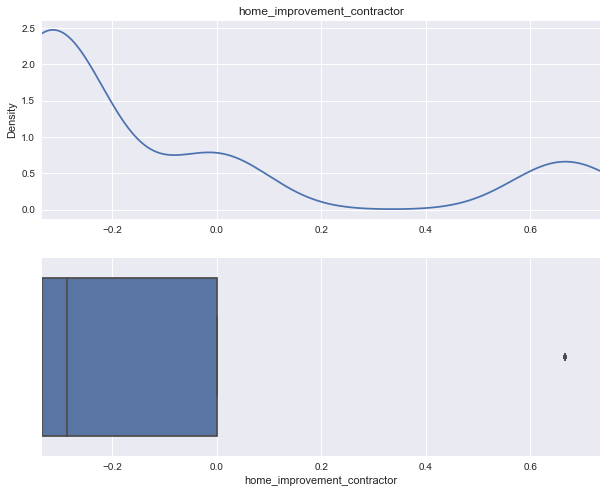

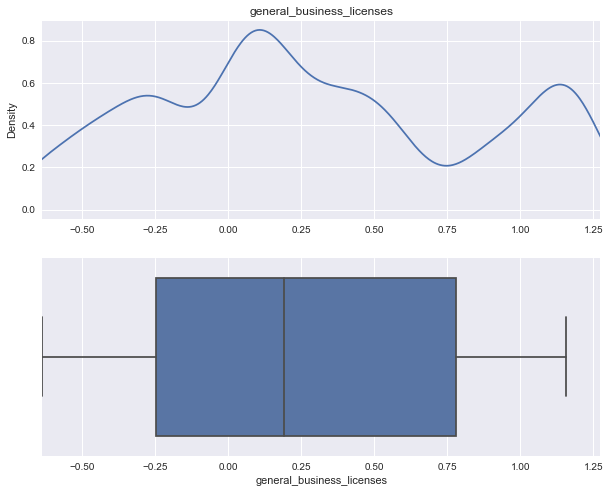

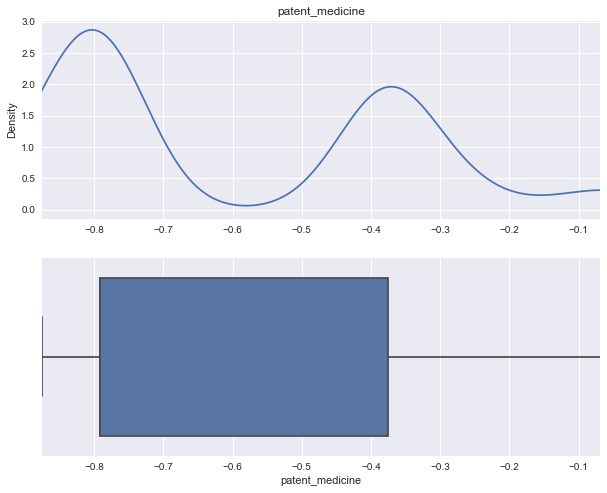

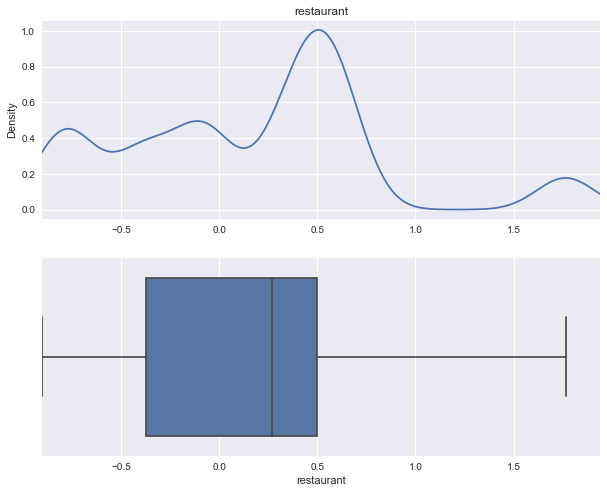

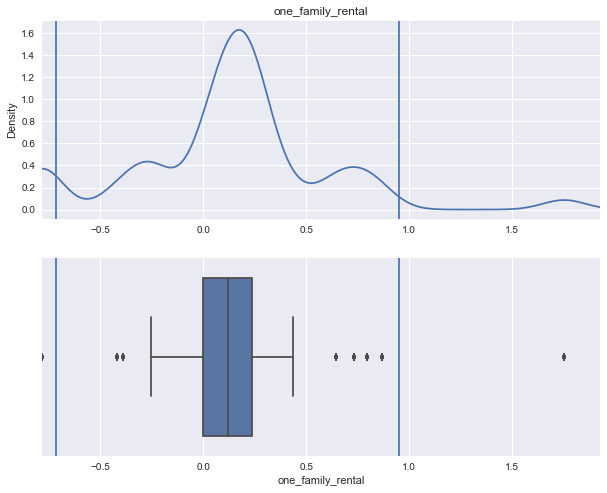

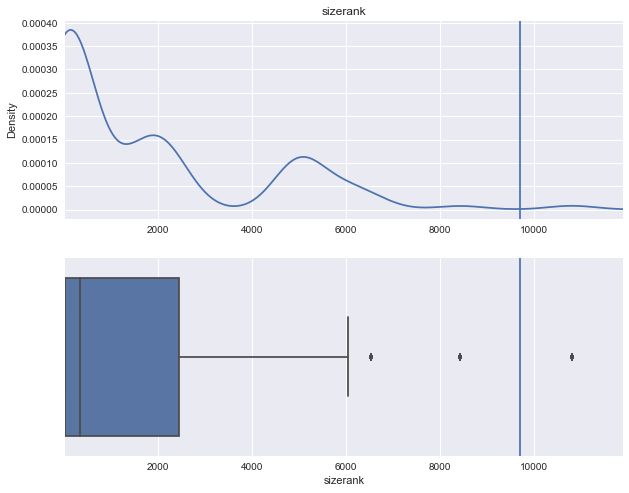

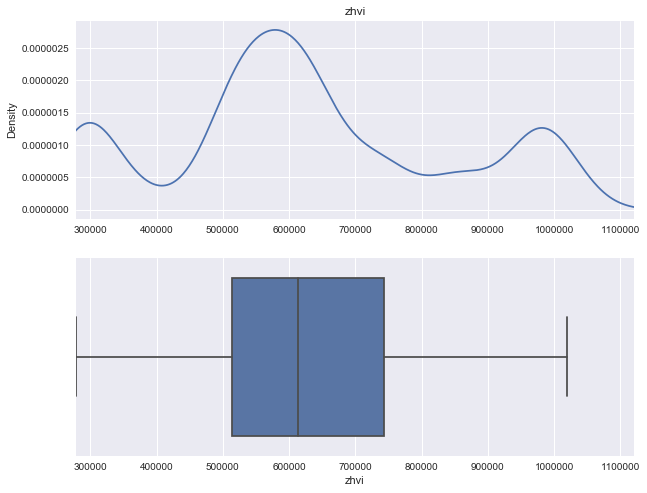

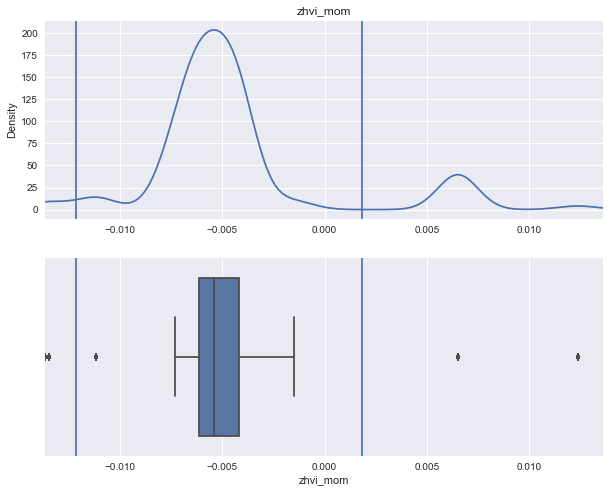

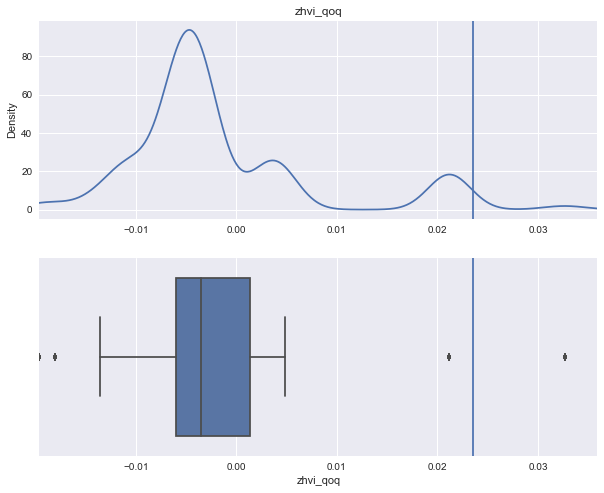

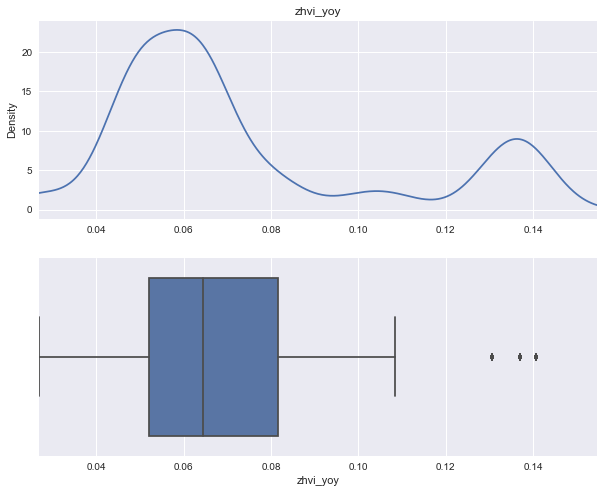

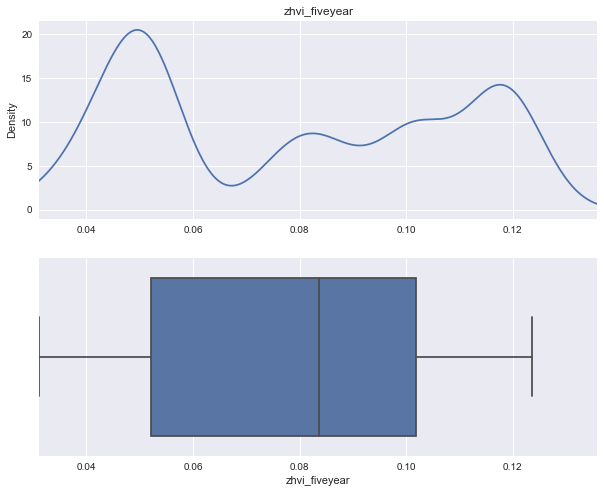

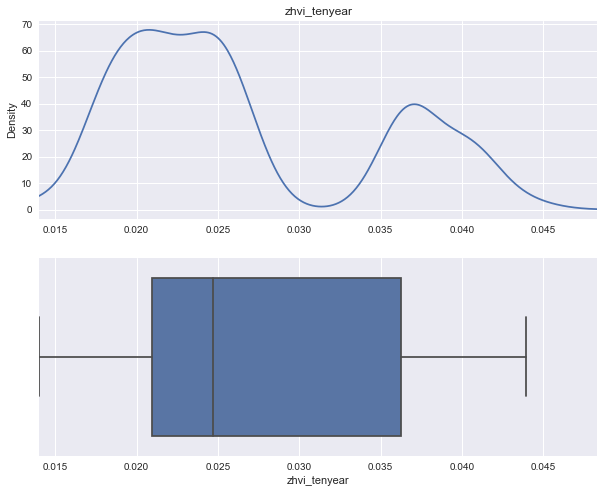

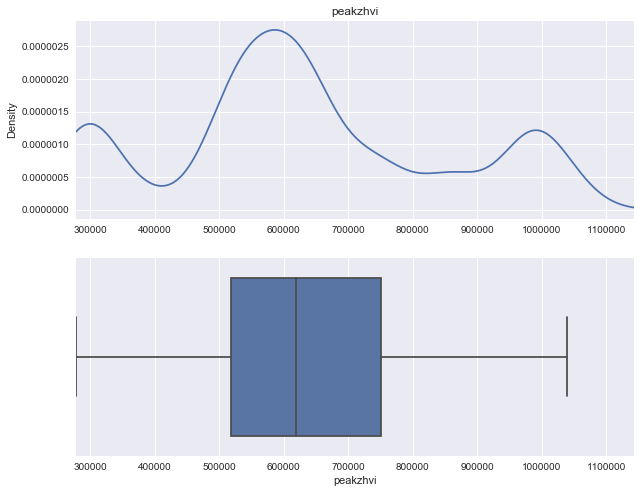

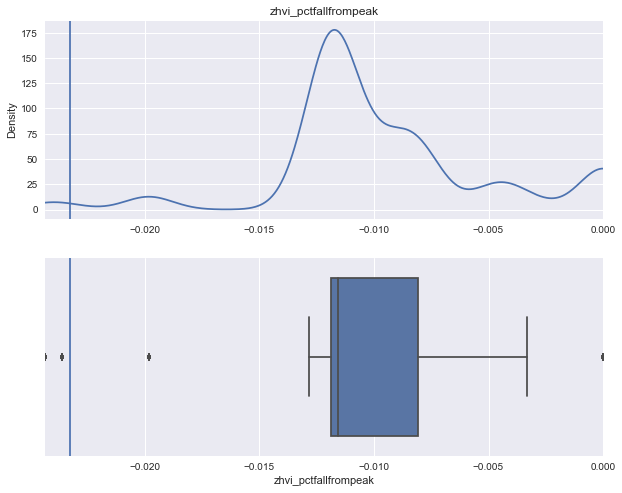

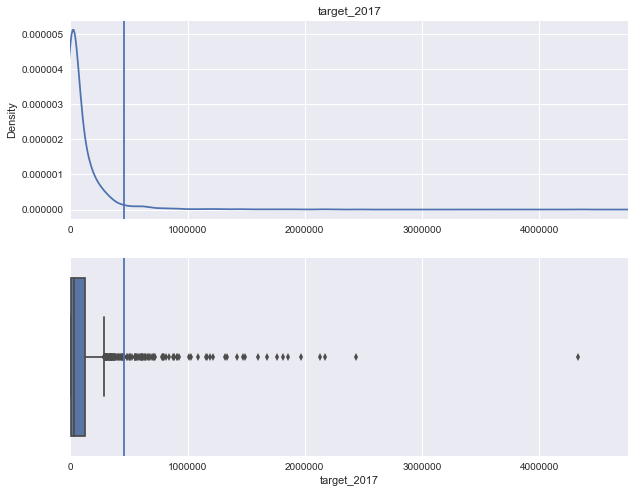

In [61]:
# Plot Density and BoxPlots to understand feature distribution

numerics = list(merged4.select_dtypes(include=[np.number]).columns.values)

for i in numerics:
    
        
    q25, q75 = np.percentile(merged4[i].dropna(), [25 ,75])
    iqr = q75 - q25

    min = q25 - (iqr*3)
    max = q75 + (iqr*3)
    
    plt.figure(figsize=(10,8))
    plt.subplot(211)
    plt.xlim(merged4[i].min(), merged4[i].max()*1.1)
    plt.axvline(x=min)
    plt.axvline(x=max)
    plt.title(i)
    ax = merged4[i].plot(kind='kde')

    plt.subplot(212)
    plt.xlim(merged4[i].min(), merged4[i].max()*1.1)
    sns.boxplot(x=merged4[i])
    plt.axvline(x=min)
    plt.axvline(x=max)
    
    sns.plt.show()

## Takeaways from Initial Visual Analysis

#### 1. Functional form of some variables may need to be changed
For example, lotsizesqft and taxassessment may benefit from transforming into Log form

#### 2. Many fields have extreme values that need to be treated
In this case, exclude values above 99th percentile

#### 3. Features w/multimodal distributions need to be assessed more closely
For example, two building booms can be observed in DC. Features leveraging this info may be useful.

#### 4. Additional derived features can be created
For example, performance and feature importance may differ by property sqft

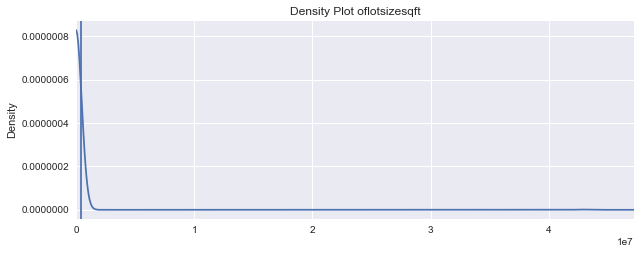

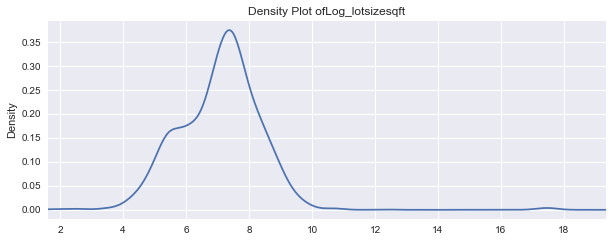

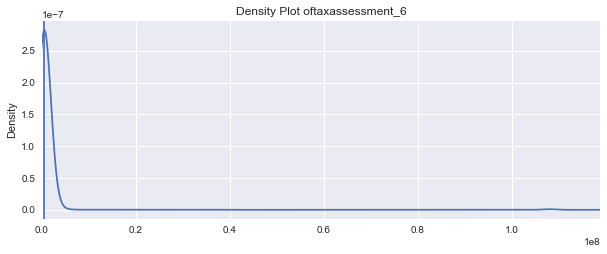

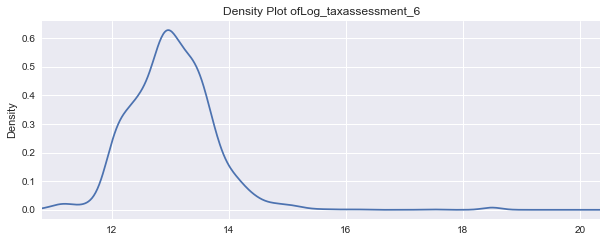

In [62]:
# Create Log form of lotsizesqft and taxassessment
merged5 = merged4
var = ('lotsizesqft', 'taxassessment_6')

for j in var:
    i = j
    i2 = 'Log_'+j
    merged5.loc[:,i2] = np.log(merged5[i])

    plt.figure(figsize=(10,8))
    plt.subplot(211)
    plt.xlim(merged5[i].min(), merged5[i].max()*1.1)
    plt.axvline(x=min)
    plt.axvline(x=max)
    ax = merged5[i].plot(kind='kde')
    plt.title('Density Plot of'+i)

    plt.figure(figsize=(10,8))
    plt.subplot(211)
    plt.xlim(merged5[i2].min(), merged5[i2].max()*1.1)
    plt.axvline(x=min)
    plt.axvline(x=max)
    ax = merged5[i2].plot(kind='kde')
    plt.title('Density Plot of'+i2)

    sns.plt.show()

In [63]:
merged4.dtypes

bedrooms                                int64
bathrooms                             float64
yearbuilt                               int64
lotsizesqft                             int64
taxassessment_6                       float64
finishedsqft                            int64
for_sale                                int64
zpid                                  float64
street                                 object
city                                   object
state                                  object
zipcode                                object
zestimate_1                           float64
zestimate_6                           float64
percentile_1                          float64
percentile_6                          float64
lastsolddate_6                 datetime64[ns]
lastsoldprice_6                       float64
bbl_pct_chg_1617                      float64
bbl_pct_chg_1217                      float64
barber_shop                           float64
cigarette_retail                  

In [64]:
# Remove obs w/values above 99th percentile

numerics = list(merged5.select_dtypes(include=[np.number]).columns.values)
numerics.remove('zpid')
numerics.remove('target_2017')

for i in numerics:
    qmax = merged5[i].quantile(0.99) 
    merged5[merged5[i] < qmax] 
    
merged5.shape

(1899, 56)

In [65]:
# Create flags for build date
merged5['built_after_2000'] = merged5['yearbuilt'] > 2000
merged5.loc[:,'built_after_2000'] = merged5['built_after_2000'].astype(int)


/Users/gbq483/anaconda/lib/python2.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [66]:
merged5.head(10)

,bedrooms,bathrooms,yearbuilt,lotsizesqft,taxassessment_6,finishedsqft,for_sale,zpid,street,city,...,zhvi_fiveyear,zhvi_tenyear,zhvi_peakmonth,peakzhvi,zhvi_pctfallfrompeak,lasttimeatcurrzhvi,target_2017,Log_lotsizesqft,Log_taxassessment_6,built_after_2000
lastsolddate_6,,,,,,,,,,,,,,,,,,,,,
2017-01-18,4,7.0,2010,17777,10600000.0,10897,1,1.084285e+08,2815 Woodland Dr NW,Washington,...,0.044144,0.018017,2017-03-01,860100.0,-0.004651,2017-03-01,1766512.0,9.785661,16.176365,1
2017-06-30,2,2.0,1908,565,367380.0,946,1,2.101223e+09,1 Logan Cir NW,Washington,...,0.044807,0.023858,2017-03-01,519000.0,-0.010212,2017-02-01,350228.0,6.336826,12.814152,0
2017-05-12,2,2.0,1938,1552,162050.0,832,0,5.092020e+05,3427 Eads St NE,Washington,...,0.119687,0.020936,2017-05-01,293900.0,0.000000,2017-05-01,1057.0,7.347300,11.995660,0
2017-07-10,4,4.0,2017,756,523750.0,1700,1,2.093799e+09,2803 Sherman Ave NW # 2,Washington,...,0.083636,0.040571,2017-03-01,653800.0,-0.009483,2017-02-01,146533.0,6.628041,13.168770,1
2017-04-05,3,1.5,1946,1999,186130.0,1998,0,5.158770e+05,4707 Bass Pl SE,Washington,...,0.119687,0.020936,2017-05-01,293900.0,0.000000,2017-05-01,170811.0,7.600402,12.134201,0
2017-05-01,2,1.0,1942,1564,435760.0,1175,0,4.473660e+05,3880 Porter St NW APT E353,Washington,...,0.052494,0.026411,2017-03-01,991200.0,-0.008172,2017-02-01,8254.0,7.355002,12.984847,0
2017-01-10,2,1.0,1942,1502,162280.0,960,1,2.093810e+09,3311 Clay Pl NE # KINGMAN,Washington,...,0.119687,0.020936,2017-05-01,293900.0,0.000000,2017-05-01,75322.0,7.314553,11.997079,0
2017-04-12,3,2.0,1920,5000,219310.0,1456,0,6.807167e+07,5602 Clay Pl NE,Washington,...,0.119687,0.020936,2017-05-01,293900.0,0.000000,2017-05-01,118608.0,8.517193,12.298242,0
2017-06-05,3,2.0,1905,12000,315050.0,1802,0,5.255490e+05,2331 High St SE,Washington,...,0.114632,0.018479,2017-03-01,311800.0,-0.012829,2017-01-01,119284.0,9.392662,12.660487,0


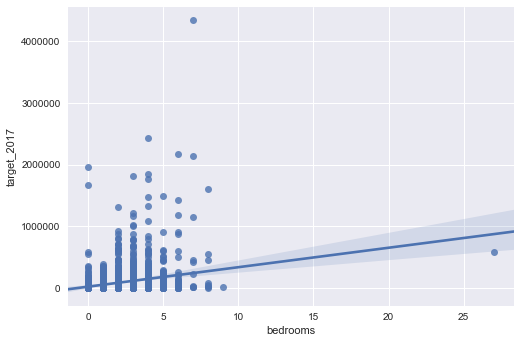

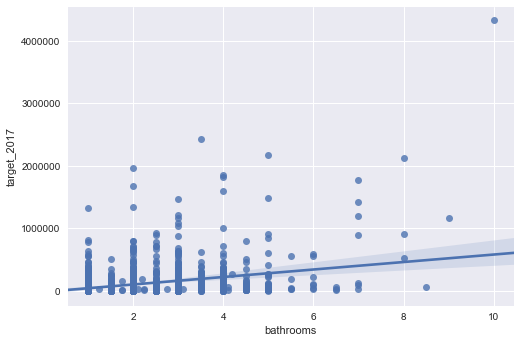

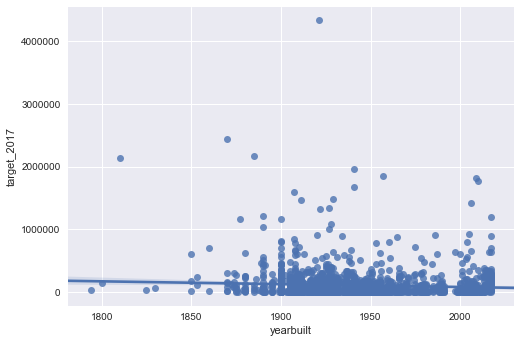

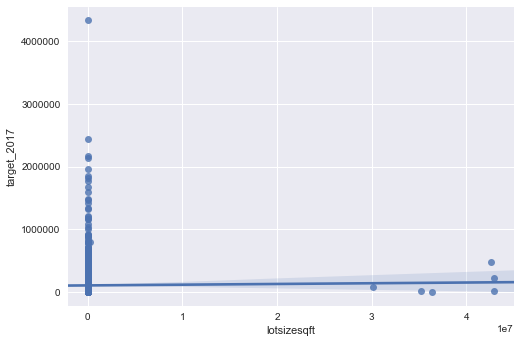

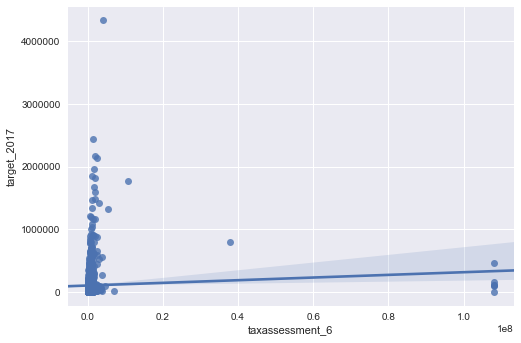

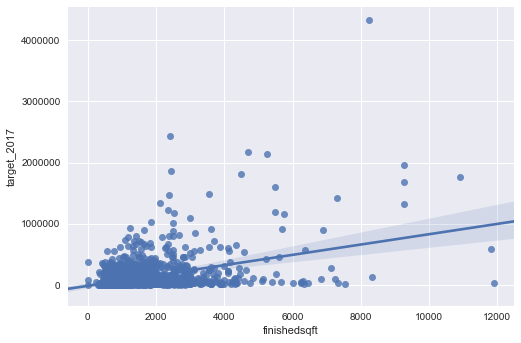

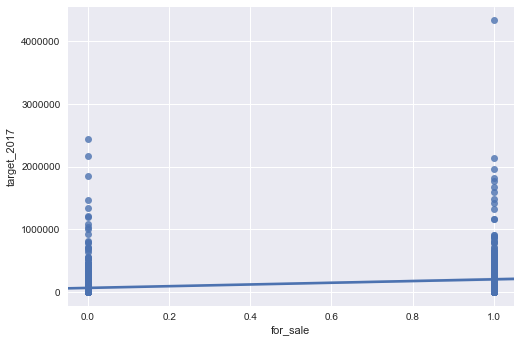

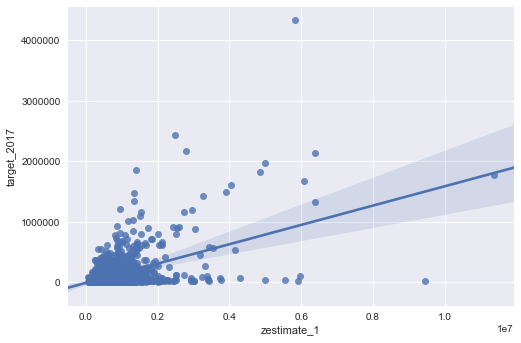

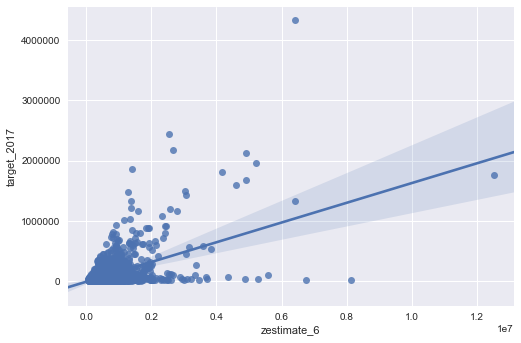

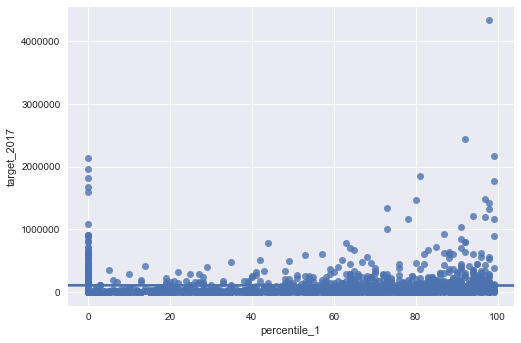

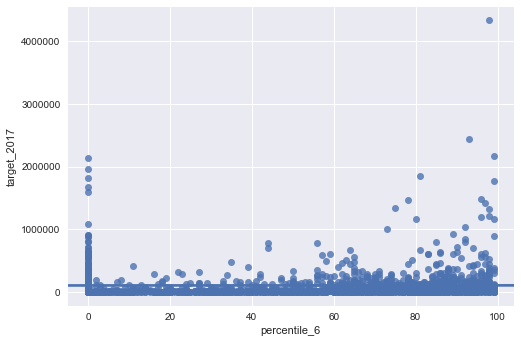

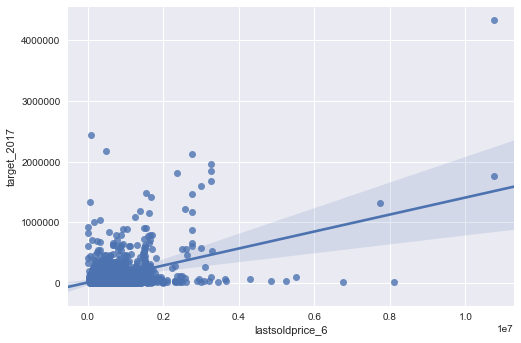

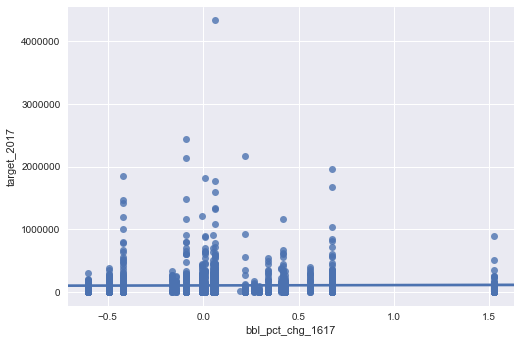

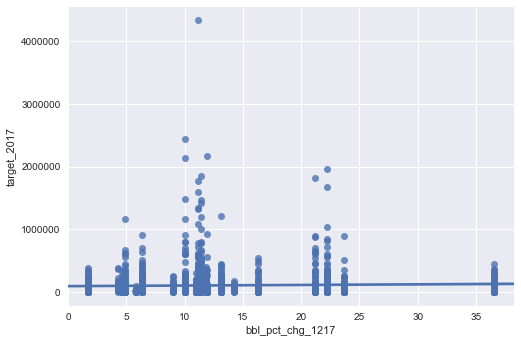

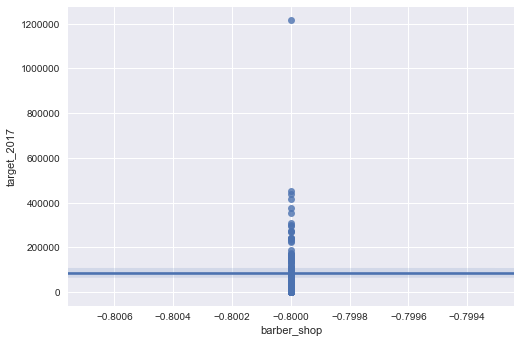

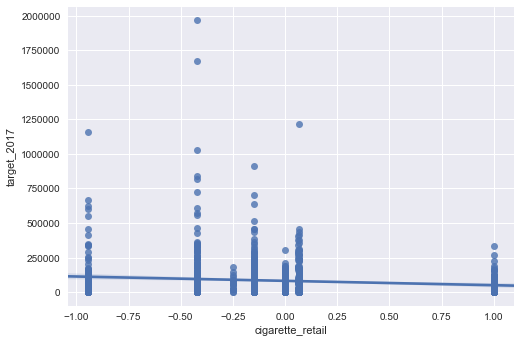

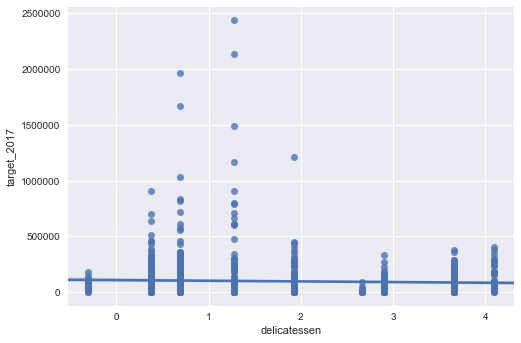

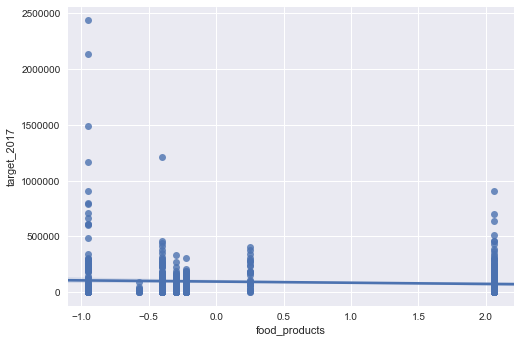

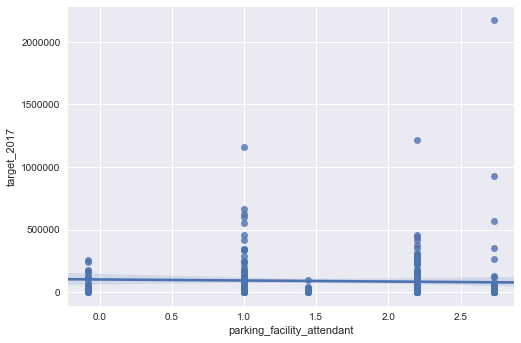

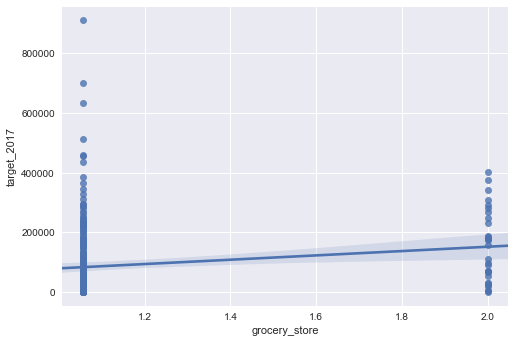

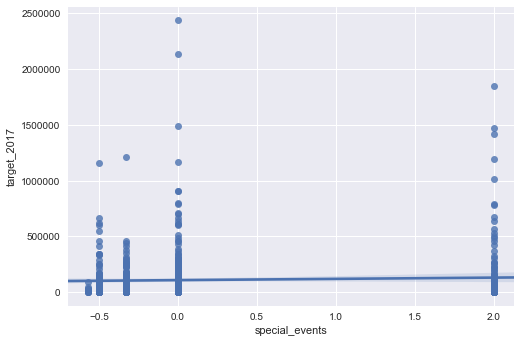

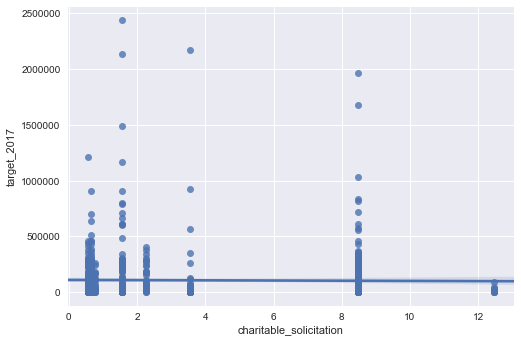

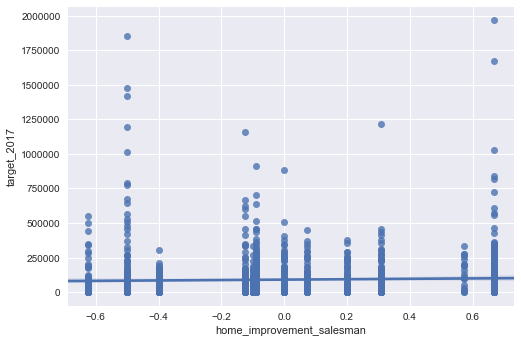

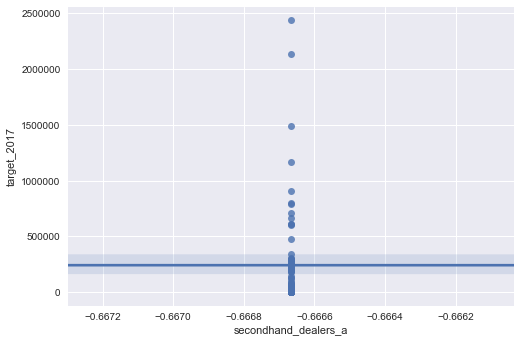

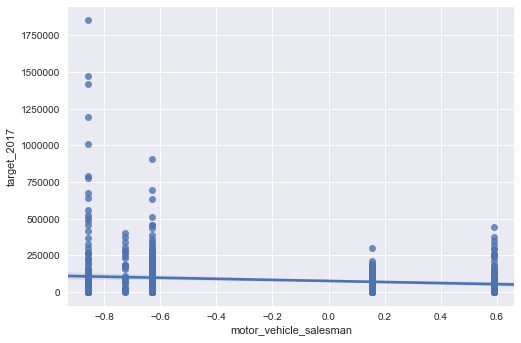

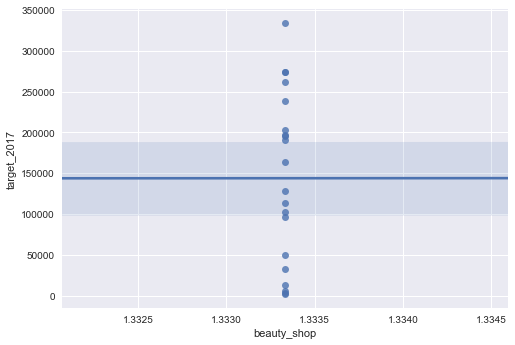

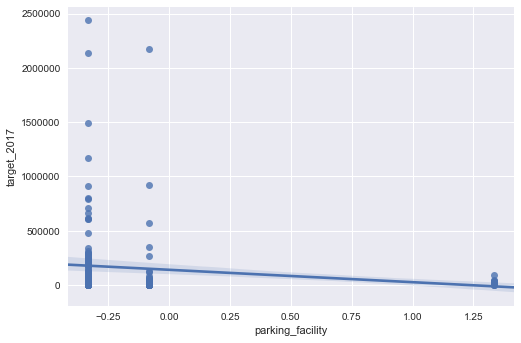

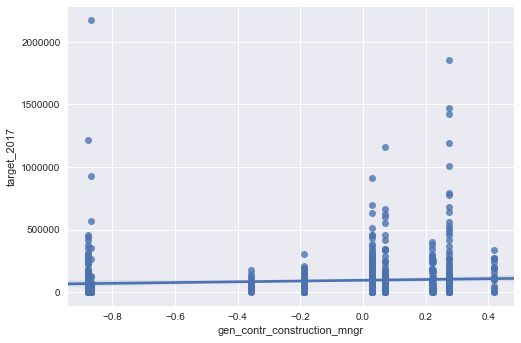

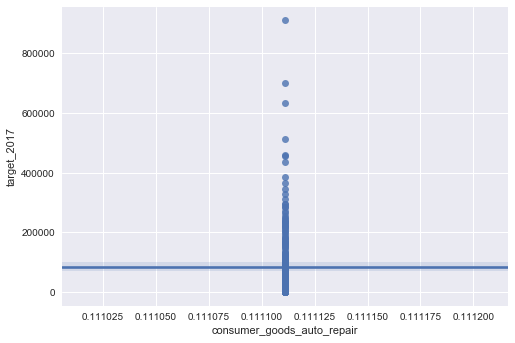

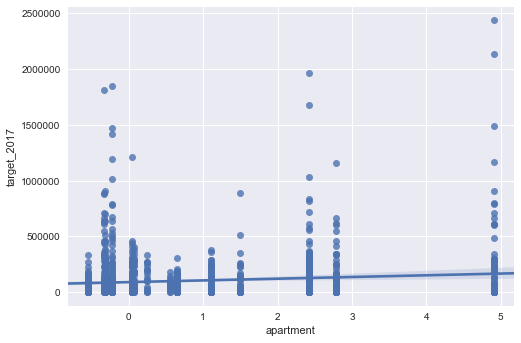

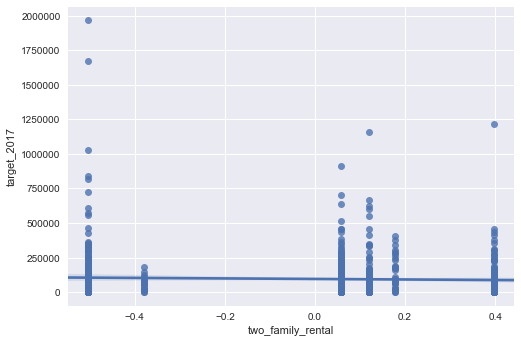

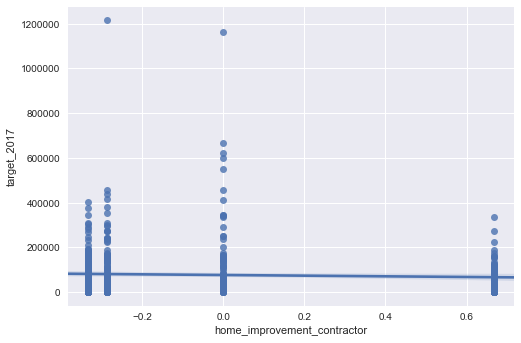

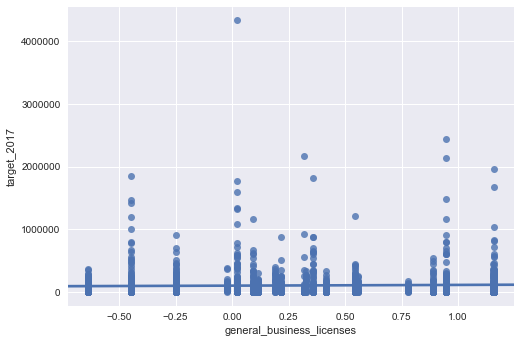

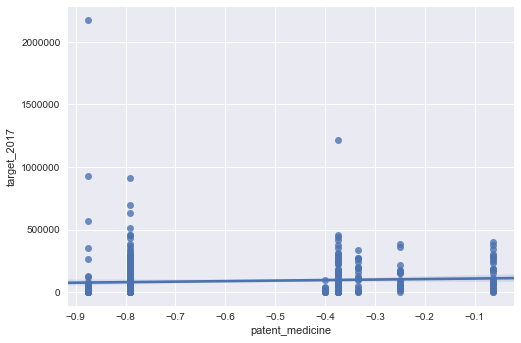

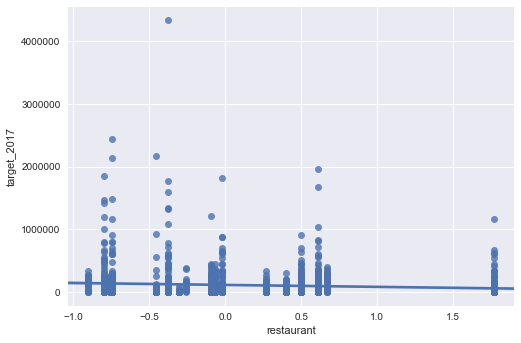

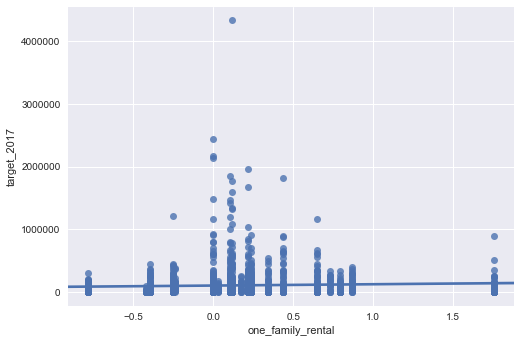

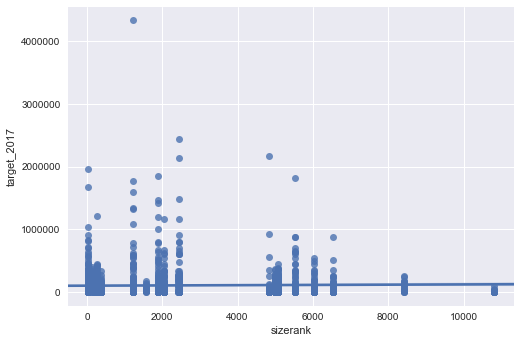

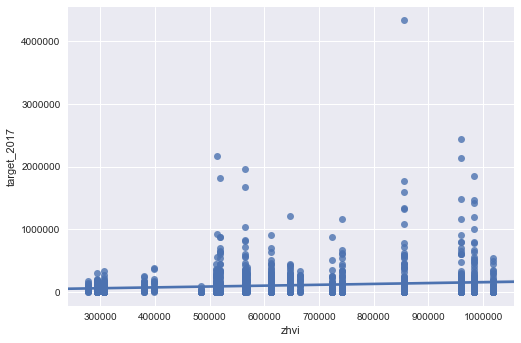

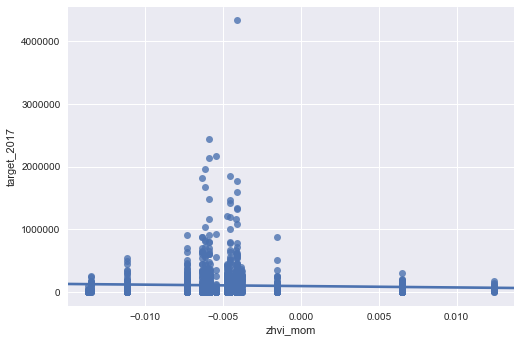

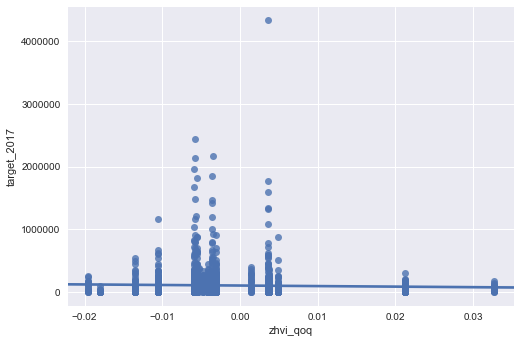

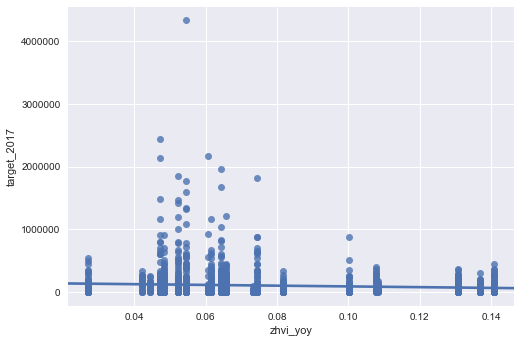

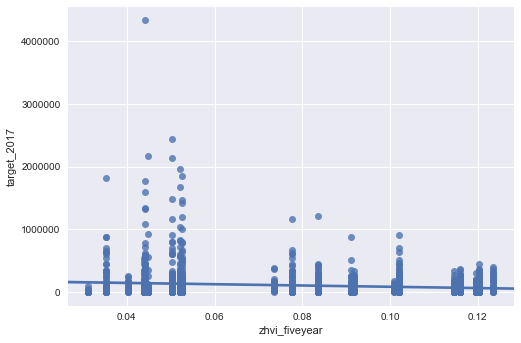

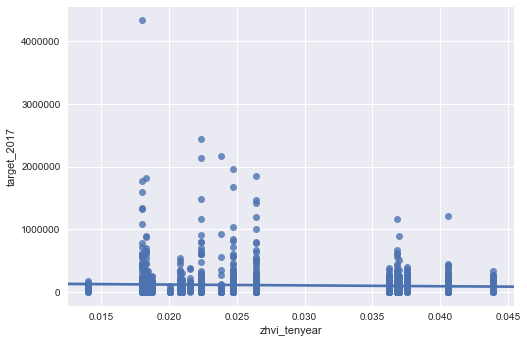

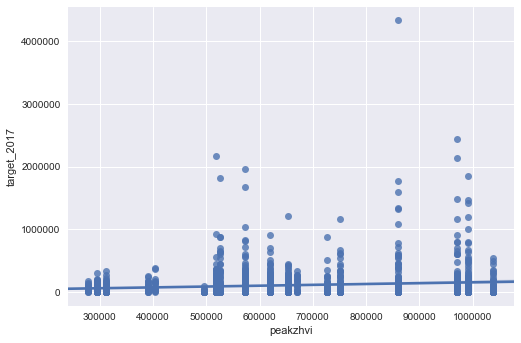

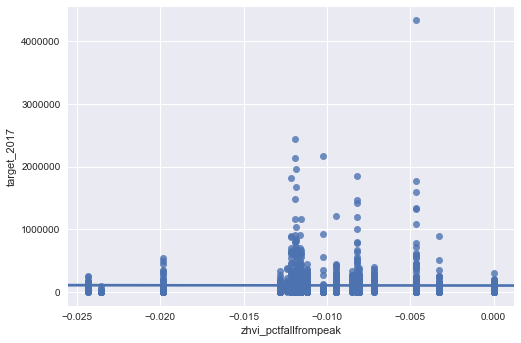

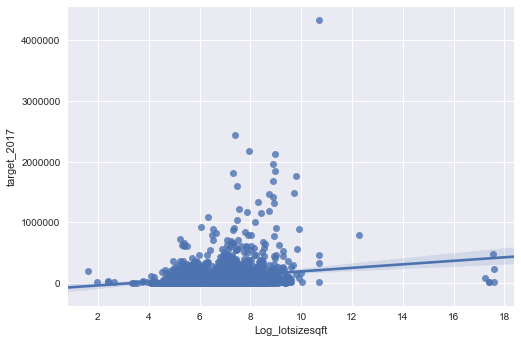

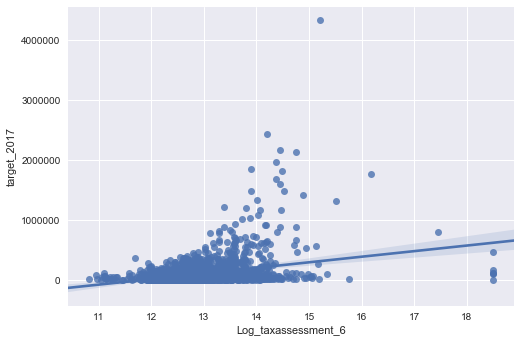

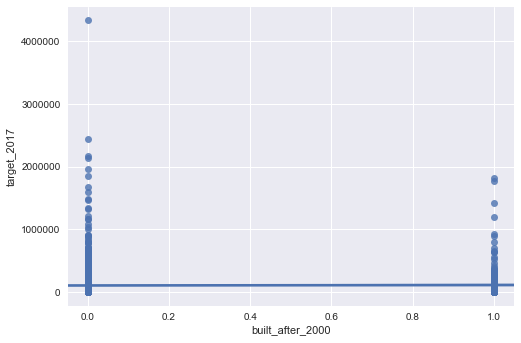

In [67]:
# Plot metrics against the target

numerics = list(merged5.select_dtypes(include=[np.number]).columns.values)
numerics.remove('zpid')
numerics.remove('target_2017')

for i in numerics:

    g = sns.regplot(x=i, y="target_2017", data=merged5)
    sns.plt.show()

In [68]:
# Define feature and target lists and view correlation of features

numerics = list(merged5.select_dtypes(include=[np.number]).columns.values)
numerics.remove('zpid')

numerics2 = merged5[numerics]

f, ax = plt.subplots(figsize=(30, 30))
corr = numerics2.corr()
# sns.heatmap(corr, mask=np.zeros_like(corr, dtype=np.bool), cmap=sns.diverging_palette(220, 10, as_cmap=True),
#             square=True, ax=ax)
# sns.plt.show()
cmap = cmap=sns.diverging_palette(5, 250, as_cmap=True)

def magnify():
    return [dict(selector="th",
                 props=[("font-size", "7pt")]),
            dict(selector="td",
                 props=[('padding', "0em 0em")]),
            dict(selector="th:hover",
                 props=[("font-size", "12pt")]),
            dict(selector="tr:hover td:hover",
                 props=[('max-width', '200px'),
                        ('font-size', '12pt')])
]

corr.style.background_gradient(cmap, axis=1)\
    .set_properties(**{'max-width': '80px', 'font-size': '10pt'})\
    .set_caption("Hover to magify")\
    .set_precision(2)\
    .set_table_styles(magnify())


In [69]:
# Remove the following features based on correlation and intuition
numerics = list(merged5.select_dtypes(include=[np.number]).columns.values)
numerics.remove('zpid')
numerics.remove('zestimate_1')
numerics.remove('zestimate_6')
numerics.remove('percentile_1')
numerics.remove('percentile_6')
numerics.remove('lastsoldprice_6')
numerics.remove('barber_shop')
numerics.remove('cigarette_retail')
numerics.remove('delicatessen')
numerics.remove('food_products')
numerics.remove('parking_facility_attendant')
numerics.remove('grocery_store')
numerics.remove('special_events')
numerics.remove('charitable_solicitation')
numerics.remove('home_improvement_salesman')
numerics.remove('secondhand_dealers_a')
numerics.remove('motor_vehicle_salesman')
numerics.remove('beauty_shop')
numerics.remove('parking_facility')
numerics.remove('gen_contr_construction_mngr')
numerics.remove('consumer_goods_auto_repair')
numerics.remove('apartment')
numerics.remove('two_family_rental')
numerics.remove('home_improvement_contractor')

numerics2 = merged5[numerics]

f, ax = plt.subplots(figsize=(30, 30))
corr = numerics2.corr()
# sns.heatmap(corr, mask=np.zeros_like(corr, dtype=np.bool), cmap=sns.diverging_palette(220, 10, as_cmap=True),
#             square=True, ax=ax)
# sns.plt.show()
cmap = cmap=sns.diverging_palette(5, 250, as_cmap=True)

def magnify():
    return [dict(selector="th",
                 props=[("font-size", "7pt")]),
            dict(selector="td",
                 props=[('padding', "0em 0em")]),
            dict(selector="th:hover",
                 props=[("font-size", "12pt")]),
            dict(selector="tr:hover td:hover",
                 props=[('max-width', '200px'),
                        ('font-size', '12pt')])
]

corr.style.background_gradient(cmap, axis=1)\
    .set_properties(**{'max-width': '80px', 'font-size': '10pt'})\
    .set_caption("Hover to magify")\
    .set_precision(2)\
    .set_table_styles(magnify())


,bedrooms,bathrooms,yearbuilt,lotsizesqft,taxassessment_6,finishedsqft,for_sale,bbl_pct_chg_1617,bbl_pct_chg_1217,general_business_licenses,patent_medicine,restaurant,one_family_rental,sizerank,zhvi,zhvi_mom,zhvi_qoq,zhvi_yoy,zhvi_fiveyear,zhvi_tenyear,peakzhvi,zhvi_pctfallfrompeak,target_2017,Log_lotsizesqft,Log_taxassessment_6,built_after_2000
bedrooms,1,0.71,-0.18,-0.02,-0.0062,0.65,-0.053,-0.06,-0.039,-0.091,-0.0031,0.013,0.044,-0.0055,0.089,0.079,0.1,0.096,0.18,0.031,0.088,0.11,0.2,0.54,0.35,-0.11
bathrooms,0.71,1,-0.075,-0.032,0.017,0.7,-0.025,-0.042,-0.0025,-0.068,0.037,-0.043,0.061,0.048,0.19,-0.013,0.015,0.0015,0.039,0.069,0.19,0.037,0.31,0.45,0.47,0.013
yearbuilt,-0.18,-0.075,1,-0.016,0.035,-0.11,0.077,-0.098,0.0076,-0.072,0.098,-0.15,-0.084,0.22,-0.079,0.043,0.045,0.13,-0.027,-0.05,-0.079,0.028,-0.073,-0.2,-0.1,0.73
lotsizesqft,-0.02,-0.032,-0.016,1,-0.0031,-0.015,0.065,-0.022,0.0021,-0.0029,0.03,-0.033,-0.011,-0.0056,0.027,-0.013,-0.018,-0.025,-0.02,0.027,0.027,-0.0078,0.011,0.43,0.0099,-0.023
taxassessment_6,-0.0062,0.017,0.035,-0.0031,1,0.04,0.064,-0.0091,0.067,0.0059,0.034,-0.035,0.045,0.092,0.013,-0.041,-0.038,-0.028,-0.12,-0.066,0.013,-0.038,0.057,-0.00063,0.5,0.0051
finishedsqft,0.65,0.7,-0.11,-0.015,0.04,1,0.023,-0.02,0.014,-0.049,0.051,-0.11,0.071,0.05,0.26,-0.047,-0.018,-0.09,-0.088,-0.019,0.26,0.02,0.41,0.47,0.54,-0.032
for_sale,-0.053,-0.025,0.077,0.065,0.064,0.023,1,0.027,0.0016,0.063,0.35,0.0082,0.06,0.036,-0.11,0.072,0.053,0.083,0.065,-0.022,-0.11,0.022,0.27,0.038,-0.026,0.066
bbl_pct_chg_1617,-0.06,-0.042,-0.098,-0.022,-0.0091,-0.02,0.027,1,0.38,0.53,0.25,0.46,0.71,0.066,0.042,-0.4,-0.47,-0.31,-0.27,0.083,0.045,-0.4,0.01,-0.17,0.16,0.037
bbl_pct_chg_1217,-0.039,-0.0025,0.0076,0.0021,0.067,0.014,0.0016,0.38,1,0.7,0.36,-0.066,-0.073,0.13,0.0094,-0.034,-0.038,0.17,-0.24,-0.17,0.01,-0.041,0.032,-0.041,0.12,0.018
general_business_licenses,-0.091,-0.068,-0.072,-0.0029,0.0059,-0.049,0.063,0.53,0.7,1,0.62,0.11,-0.021,-0.03,-0.1,-0.13,-0.25,-0.046,-0.29,-0.17,-0.095,-0.3,0.028,-0.16,0.074,0.062


In [70]:
# Remove the following features based on correlation and intuition and to create reference bucket for dummy vars
numerics = list(merged5.select_dtypes(include=[np.number]).columns.values)
numerics.remove('zpid')
numerics.remove('zestimate_1')
numerics.remove('percentile_1')
numerics.remove('percentile_6')
numerics.remove('lastsoldprice_6')
numerics.remove('barber_shop')
numerics.remove('cigarette_retail')
numerics.remove('delicatessen')
numerics.remove('food_products')
numerics.remove('parking_facility_attendant')
numerics.remove('grocery_store')
numerics.remove('special_events')
numerics.remove('charitable_solicitation')
numerics.remove('home_improvement_salesman')
numerics.remove('secondhand_dealers_a')
numerics.remove('motor_vehicle_salesman')
numerics.remove('beauty_shop')
numerics.remove('parking_facility')
numerics.remove('gen_contr_construction_mngr')
numerics.remove('consumer_goods_auto_repair')
numerics.remove('apartment')
numerics.remove('two_family_rental')
numerics.remove('home_improvement_contractor')
numerics.remove('zhvi')
numerics.remove('zhvi_mom')
numerics.remove('zhvi_pctfallfrompeak')

# Create features and target data frames
features = merged5[numerics]
target = merged5[['target_2017']]


In [71]:
# Create derivations and interactions

features.loc[:,'recent_for_sale'] = (features['for_sale'] * features['built_after_2000'])
features.loc[:,'zest_to_peakzhvi'] = (features['zestimate_6'] / features['peakzhvi'])

numerics = list(features.select_dtypes(include=[np.number]).columns.values)
numerics.remove('zestimate_6')
numerics.remove('target_2017')
numerics.remove('taxassessment_6')
numerics.remove('lotsizesqft')
numerics.remove('patent_medicine')

features2 = features[numerics]
list(features2)


['bedrooms',
 'bathrooms',
 'yearbuilt',
 'finishedsqft',
 'for_sale',
 'bbl_pct_chg_1617',
 'bbl_pct_chg_1217',
 'general_business_licenses',
 'restaurant',
 'one_family_rental',
 'sizerank',
 'zhvi_qoq',
 'zhvi_yoy',
 'zhvi_fiveyear',
 'zhvi_tenyear',
 'peakzhvi',
 'Log_lotsizesqft',
 'Log_taxassessment_6',
 'built_after_2000',
 'recent_for_sale',
 'zest_to_peakzhvi']

In [72]:
# Impute nulls to mean

med = np.mean(features2.bbl_pct_chg_1217)   
features2.bbl_pct_chg_1217 = features2.bbl_pct_chg_1217.fillna(med)

med = np.mean(features2.bbl_pct_chg_1617)   
features2.bbl_pct_chg_1617 = features2.bbl_pct_chg_1617.fillna(med)

med = np.mean(features2.general_business_licenses)   
features2.general_business_licenses = features2.general_business_licenses.fillna(med)

med = np.mean(features2.restaurant)   
features2.restaurant = features2.restaurant.fillna(med)

med = np.mean(features2.one_family_rental)   
features2.one_family_rental = features2.one_family_rental.fillna(med)

med = np.mean(features2.sizerank)   
features2.sizerank = features2.sizerank.fillna(med)

med = np.mean(features2.zhvi_qoq)   
features2.zhvi_qoq = features2.zhvi_qoq.fillna(med)

med = np.mean(features2.zhvi_fiveyear)   
features2.zhvi_fiveyear = features2.zhvi_fiveyear.fillna(med)

med = np.mean(features2.zhvi_tenyear)   
features2.zhvi_tenyear = features2.zhvi_tenyear.fillna(med)

med = np.mean(features2.zhvi_yoy)   
features2.zhvi_yoy = features2.zhvi_yoy.fillna(med)

med = np.mean(features2.peakzhvi)   
features2.peakzhvi = features2.peakzhvi.fillna(med)

med = np.mean(features2.zest_to_peakzhvi)   
features2.zest_to_peakzhvi = features2.zest_to_peakzhvi.fillna(med)

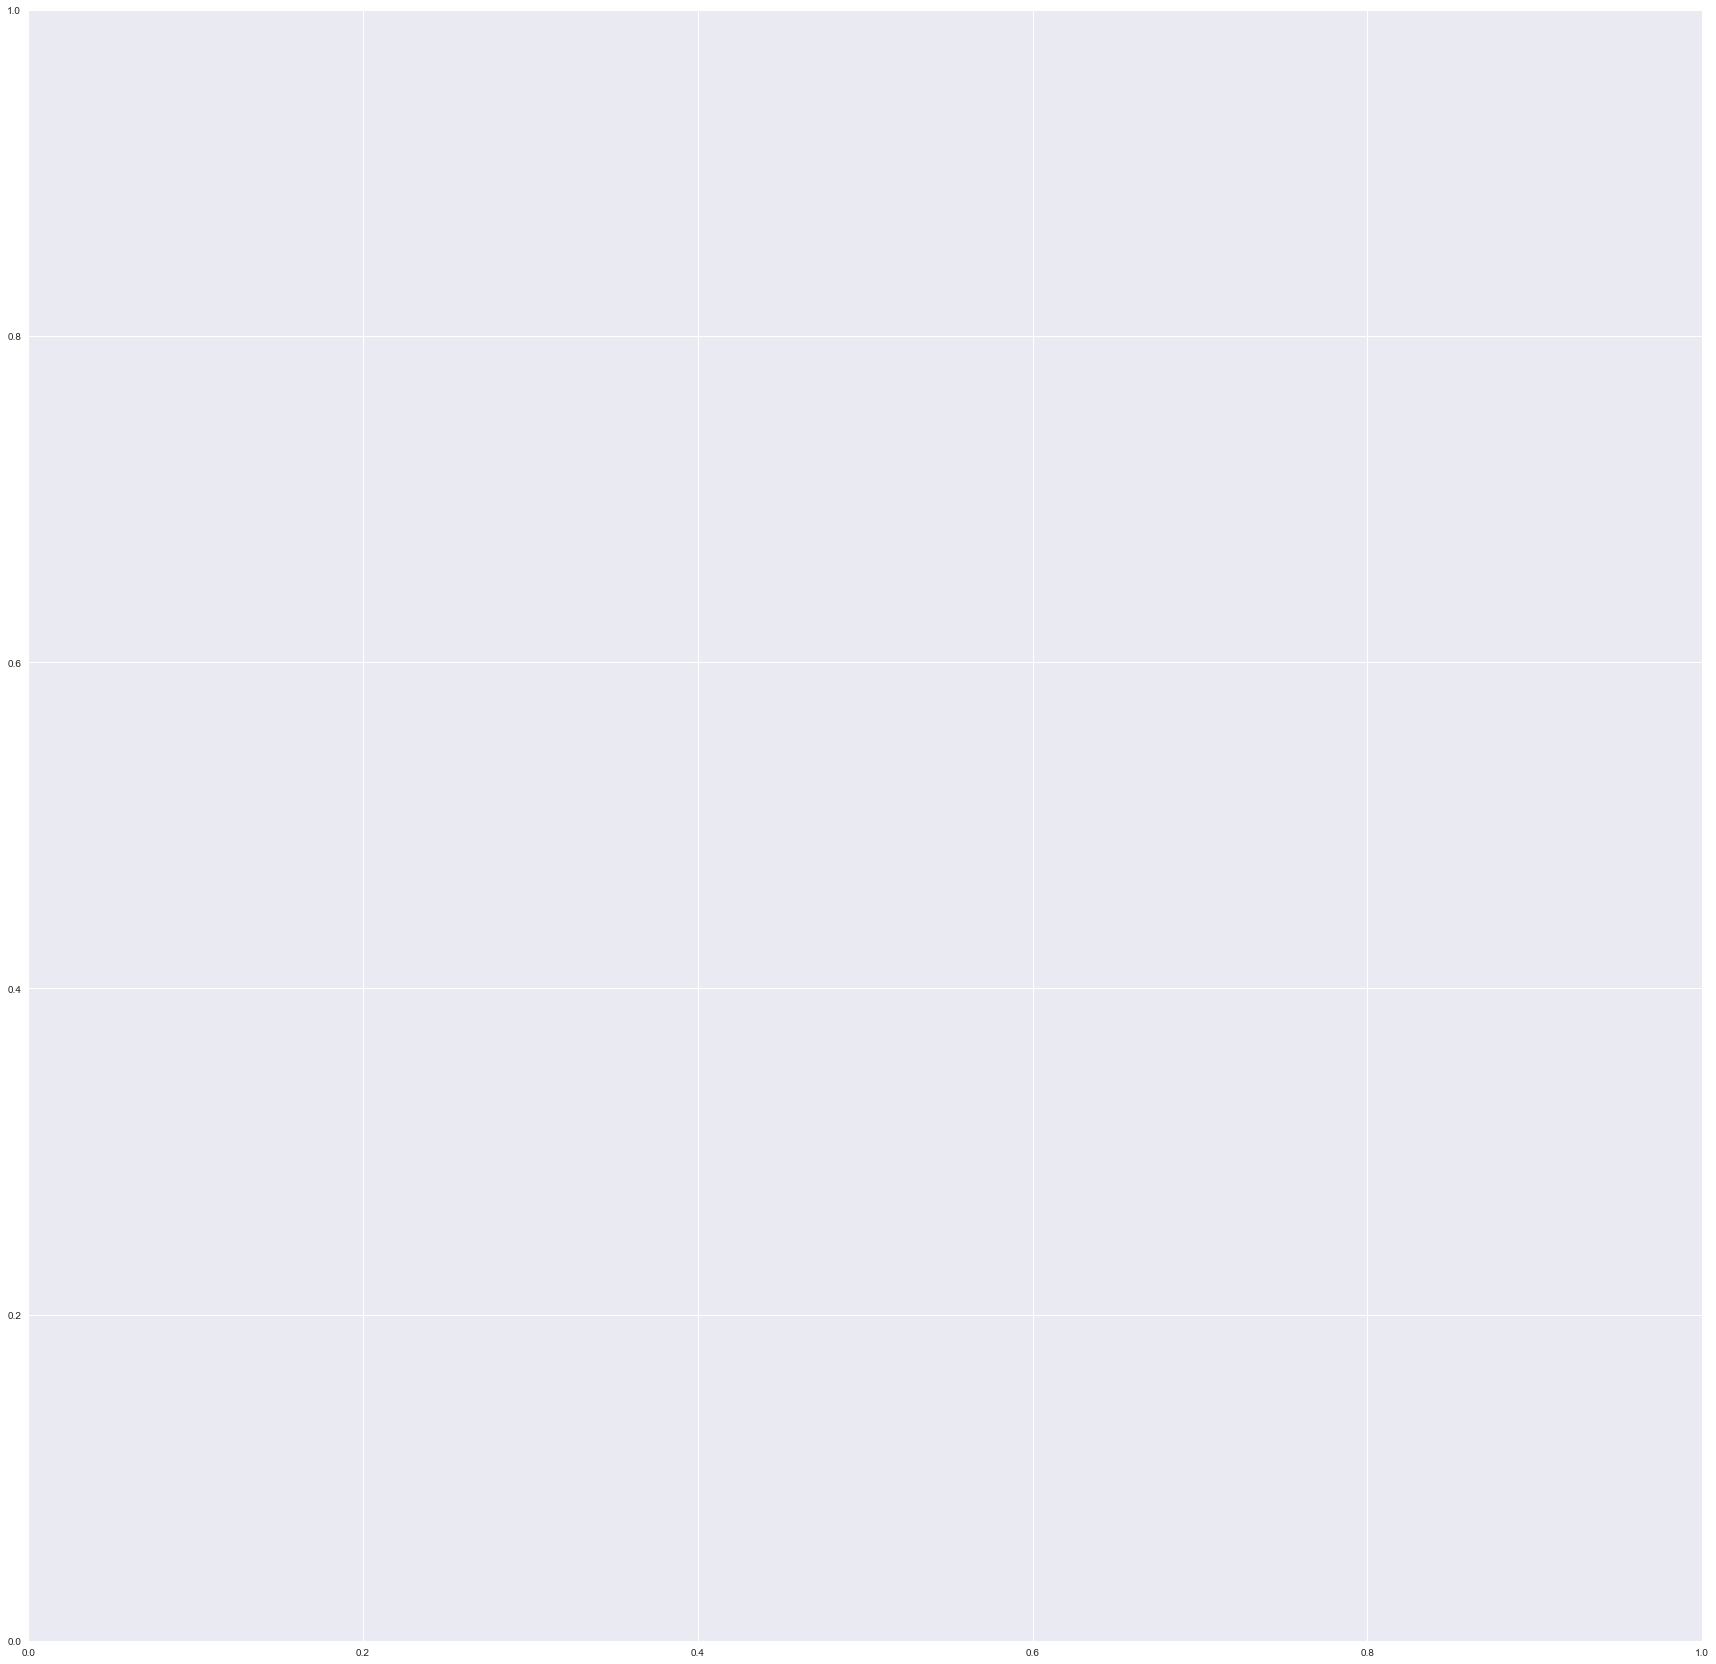

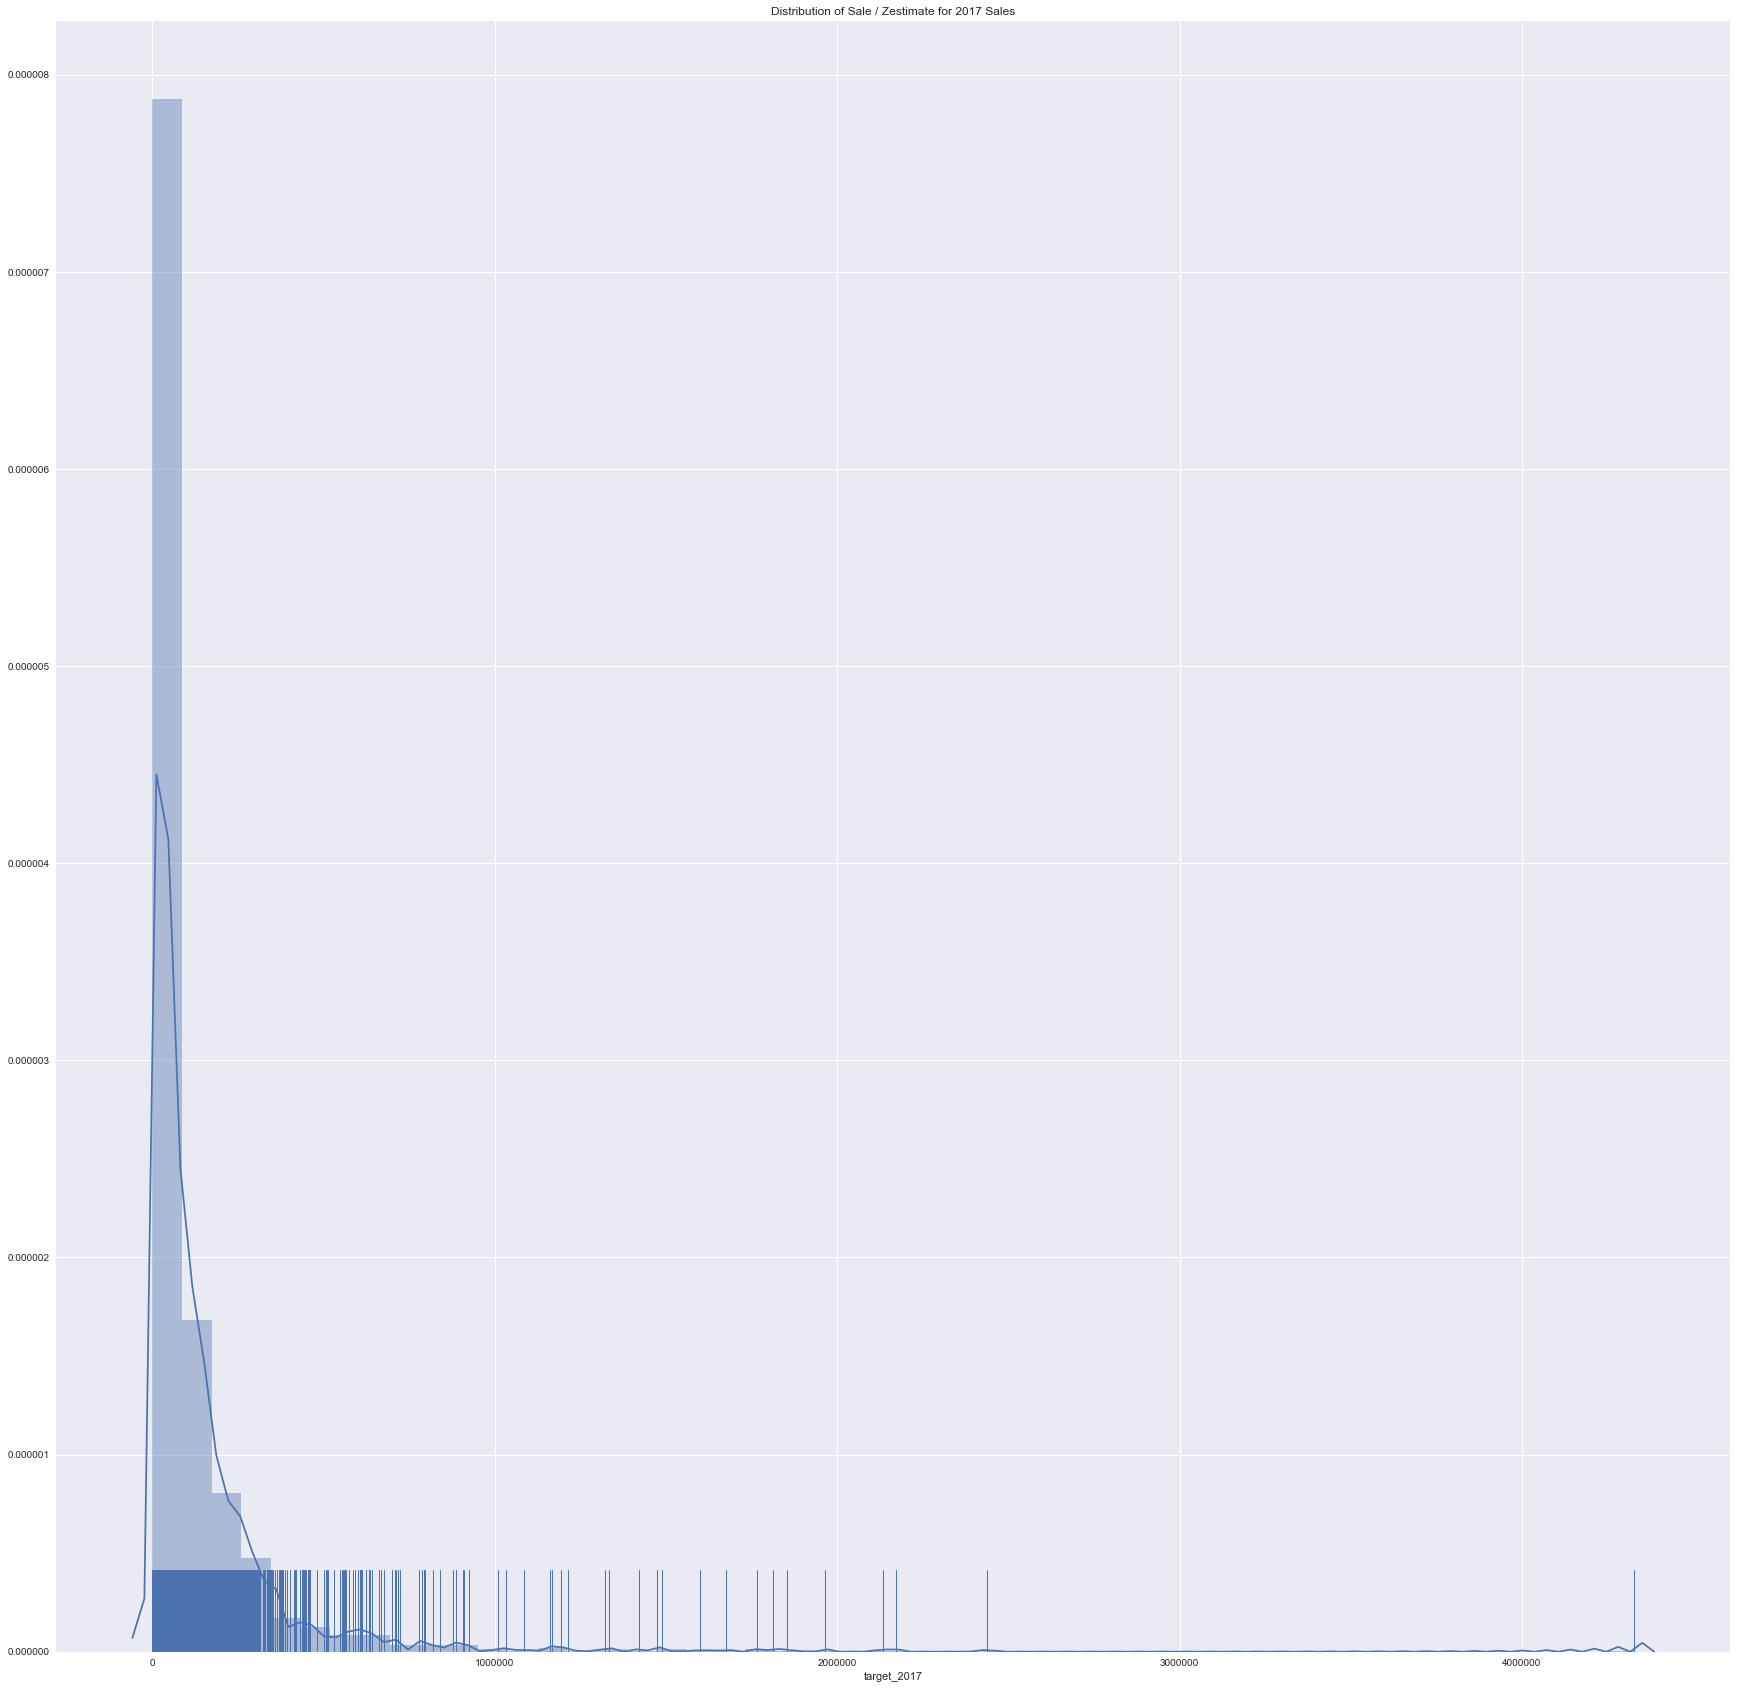

In [73]:
# Plot target variable

g = sns.distplot(target.target_2017, rug=True, kde=True)
t = g.set_title("Distribution of Sale / Zestimate for 2017 Sales")
sns.plt.show()

In [74]:
features2.head(25)

,bedrooms,bathrooms,yearbuilt,finishedsqft,for_sale,bbl_pct_chg_1617,bbl_pct_chg_1217,general_business_licenses,restaurant,one_family_rental,...,zhvi_qoq,zhvi_yoy,zhvi_fiveyear,zhvi_tenyear,peakzhvi,Log_lotsizesqft,Log_taxassessment_6,built_after_2000,recent_for_sale,zest_to_peakzhvi
lastsolddate_6,,,,,,,,,,,,,,,,,,,,,
2017-01-18,4,7.0,2010,10897,1,0.063433,11.127660,0.019802,-0.375000,0.117438,...,0.003634,0.054570,0.044144,0.018017,860100.0,9.785661,16.176365,1,1,14.552392
2017-06-30,2,2.0,1908,946,1,0.217814,11.965517,0.320069,-0.457831,0.000000,...,-0.003492,0.060706,0.044807,0.023858,519000.0,6.336826,12.814152,0,0,1.484062
2017-05-12,2,2.0,1938,832,0,-0.604412,10.955556,0.116667,0.400000,-0.783041,...,0.021195,0.136944,0.119687,0.020936,293900.0,7.347300,11.995660,0,0,0.908278
2017-07-10,4,4.0,2017,1700,1,-0.006413,13.084848,0.544737,-0.094545,-0.252366,...,-0.005681,0.065657,0.083636,0.040571,653800.0,6.628041,13.168770,1,1,1.247374
2017-04-05,3,1.5,1946,1998,0,-0.604412,10.955556,0.116667,0.400000,-0.783041,...,0.021195,0.136944,0.119687,0.020936,293900.0,7.600402,12.134201,0,0,1.125590
2017-05-01,2,1.0,1942,1175,0,-0.422730,11.432836,-0.448560,-0.795322,0.104396,...,-0.003548,0.052119,0.052494,0.026411,991200.0,7.355002,12.984847,0,0,0.497633
2017-01-10,2,1.0,1942,960,1,-0.604412,10.955556,0.116667,0.400000,-0.783041,...,0.021195,0.136944,0.119687,0.020936,293900.0,7.314553,11.997079,0,0,0.937999
2017-04-12,3,2.0,1920,1456,0,-0.604412,10.955556,0.116667,0.400000,-0.783041,...,0.021195,0.136944,0.119687,0.020936,293900.0,8.517193,12.298242,0,0,0.913944
2017-06-05,3,2.0,1905,1802,0,0.429688,4.593886,0.415929,0.266667,0.795620,...,-0.010608,0.081518,0.114632,0.018479,311800.0,9.392662,12.660487,0,0,1.221026


In [76]:
np.any(np.isnan(features2))

False

In [77]:
model = RandomizedLasso(alpha=0.1)
model.fit(features2, target['target_2017'])
names = list(features2)

print("Features sorted by their score:")
print(sorted(zip(map(lambda x: round(x, 4), model.scores_), 
                 names), reverse=True))

Features sorted by their score:
[(1.0, 'zhvi_qoq'), (1.0, 'zhvi_fiveyear'), (1.0, 'zest_to_peakzhvi'), (1.0, 'yearbuilt'), (1.0, 'sizerank'), (1.0, 'recent_for_sale'), (1.0, 'peakzhvi'), (1.0, 'for_sale'), (1.0, 'finishedsqft'), (1.0, 'built_after_2000'), (1.0, 'bedrooms'), (1.0, 'bbl_pct_chg_1217'), (1.0, 'bathrooms'), (1.0, 'Log_taxassessment_6'), (1.0, 'Log_lotsizesqft'), (0.995, 'zhvi_yoy'), (0.995, 'zhvi_tenyear'), (0.995, 'restaurant'), (0.995, 'one_family_rental'), (0.995, 'general_business_licenses'), (0.995, 'bbl_pct_chg_1617')]


In [78]:
splits = cv.train_test_split(features2, target, test_size=0.2)
X_train, X_test, y_train, y_test = splits
X_train.shape, y_train.shape

((1519, 21), (1519, 1))

In [79]:
X_test.shape, y_test.shape

((380, 21), (380, 1))

In [80]:
ridge = Ridge().fit(X_train, y_train)

# Predict on the test data: y_pred
y_pred = ridge.predict(X_test)

print('Ridge Model')
print('Root Mean Squared Error: {:.3f}'.format(np.sqrt(mse(y_test, y_pred))))
print('Mean Squared Error: {:.3f}'.format(mse(y_test, y_pred)))
print('Coefficient of Determination: {:.3f}'.format(r2_score(y_test, y_pred)))

Ridge Model
Root Mean Squared Error: 210809.138
Mean Squared Error: 44440492541.052
Coefficient of Determination: 0.159


In [81]:
print('ridge.coef_: {}'.format(ridge.coef_))
print('ridge.intercept_: {}'.format(ridge.intercept_))

ridge.coef_: [[ -1.66244936e+04   1.68075077e+04  -3.59306153e+02   1.16713011e+01
    1.39328485e+05   9.58195081e+02   8.48841193e+02  -7.70049174e+03
    4.69535637e+02   2.15717618e+03  -5.12441307e-01  -1.49846489e+04
    2.11639552e+04  -1.27431962e+05  -2.85209193e+04   1.45392417e-01
    4.29679131e+03  -3.48761907e+04   1.07653137e+04  -7.53768344e+03
    1.31769455e+05]]
ridge.intercept_: [ 931328.51824547]


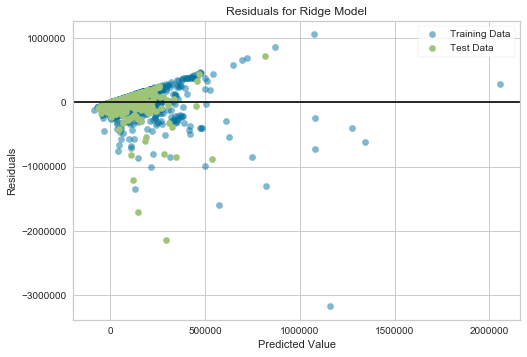

In [82]:
from yellowbrick.regressor import ResidualsPlot

visualizer = ResidualsPlot(ridge)

fig = plt.figure()
visualizer.fit(X_train, y_train)
visualizer.score(X_test, y_test)
g = visualizer.poof() 

In [83]:
model = LinearRegression()
model.fit(X_train, y_train)

expected = y_test
predicted = model.predict(X_test)

print("Linear Regression model")
print('Root Mean Squared Error: {:.3f}'.format(np.sqrt(mse(expected, predicted))))
print("Coefficient of Determination: %0.3f" % r2_score(expected, predicted))

Linear Regression model
Root Mean Squared Error: 210652.278
Coefficient of Determination: 0.160


In [84]:
model = RandomForestRegressor()
model.fit(X_train, y_train)

expected = y_test
predicted = model.predict(X_test)

print("Random Forest model")
print('Root Mean Squared Error: {:.3f}'.format(np.sqrt(mse(expected, predicted))))
print("R2 score = %0.3f" % r2_score(expected, predicted))

Random Forest model
Root Mean Squared Error: 212662.423
R2 score = 0.144


/Users/gbq483/anaconda/lib/python2.7/site-packages/ipykernel_launcher.py:2: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  
